In [1]:
import os
import datetime

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")

import pandas as pd
pd.set_option("display.max_columns", None)

OBSV_DATES = [
    datetime.date(year=2022, month=10, day=21).strftime("%Y-%m-%d"),
    # datetime.date(year=2022, month=10, day=22).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=10, day=27).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=11, day=5).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=11, day=26).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=12, day=6).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=12, day=7).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=12, day=8).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=12, day=9).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=12, day=10).strftime("%Y-%m-%d"),
]

OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"

QPHOT_DATA_DIRS = [os.path.join(OBJ_DATA_DIR, d, "corrected", "iraf-shifted", "qphot-results") for d in OBSV_DATES]
for qphotDir in QPHOT_DATA_DIRS:
    assert os.path.exists(qphotDir), f"{qphotDir} not found"

QPHOT_DATA_DIRS

['/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-10-21/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-10-27/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-11-05/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-11-26/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-06/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-07/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-08/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-09/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/

In [2]:
EPADU = 10.0

# TODO on run: update this whenever reference star targets change
STAR_LIDS = {
	1: "ATO J339.9469+45.1464", # Object

	# Ref stars
	2: "TYC 3620-332-1",
	3: "TYC 3620-254-1"
}

COMP_STAR_LID = 2 # using TYC 3620-332-1 as the constant star for quality assurance
ALT_COMP_LID = 3 if COMP_STAR_LID == 2 else 2

COMP_STAR_VMAG: float
if COMP_STAR_LID == 2:
	COMP_STAR_VMAG = 11.57 # http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%406898038&Name=TYC%203620-332-1&submit=submit
else:
	COMP_STAR_VMAG = 12.32 # http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%406898031&Name=TYC%203620-254-1&submit=submit

In [3]:
from astropy.io import ascii
from astropy.time import Time

QPHOT_RESULTS = {d:ascii.read(f"{qphotDir}/phot").to_pandas() for d, qphotDir in zip(OBSV_DATES, QPHOT_DATA_DIRS)}
for qphotDateResults in QPHOT_RESULTS.values():
    qphotDateResults['OTIME'] = pd.to_datetime(qphotDateResults['OTIME']).dt.tz_localize('America/Monterrey')
    times = Time(qphotDateResults['OTIME'])
    qphotDateResults['julianDate'] = times.tdb.jd
    qphotDateResults.sort_values(by='julianDate', inplace=True)
    # print(times.tdb.jd)
    # help(t)
    # qphotDateResults['julianDatePandas'] = qphotDateResults['OTIME'].map(lambda d: d.to_julian_date())
    # qphotDateResults.sort_values(by='julianDatePandas', inplace=True)
    # print(qphotDateResults['julianDatePandas'].iloc[0], qphotDateResults['julianDatePandas'].iloc[-1], "|", 
    #         times.jd[0], times.jd[-1], "|", 
    #         times.tdb.jd[0], times.tdb.jd[-1])
    # break


/tmp/ipykernel_485295/4078409080.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{rid} - {qphotDateResults[f'RAPERT{rid}'].iloc[0]}" for rid in rapertDataVariance.keys()])


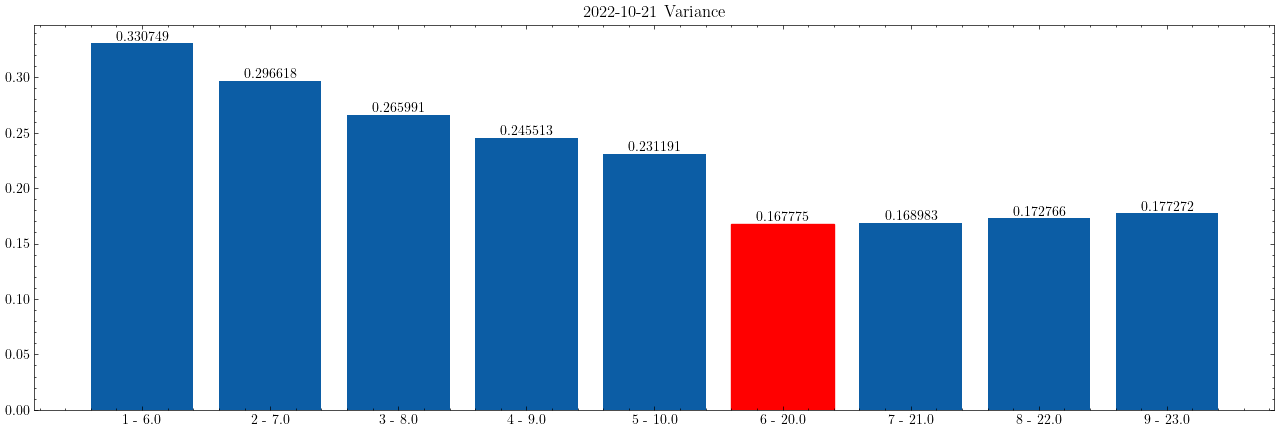

/tmp/ipykernel_485295/4078409080.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{rid} - {qphotDateResults[f'RAPERT{rid}'].iloc[0]}" for rid in rapertDataVariance.keys()])


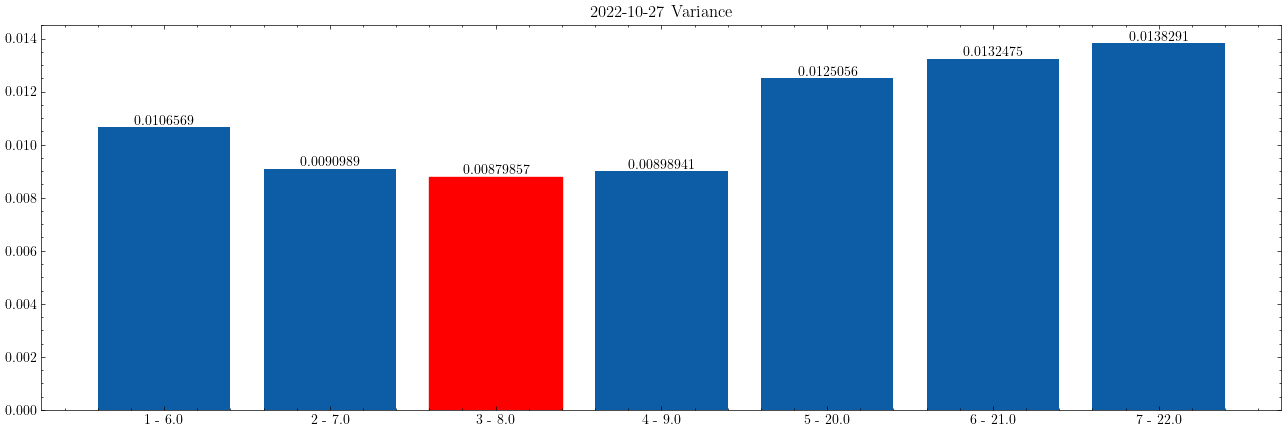

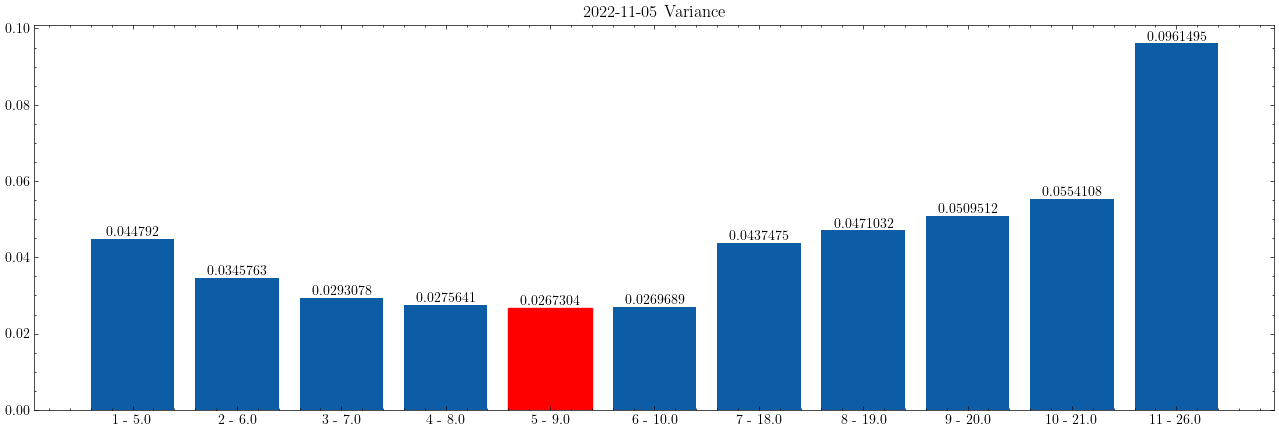

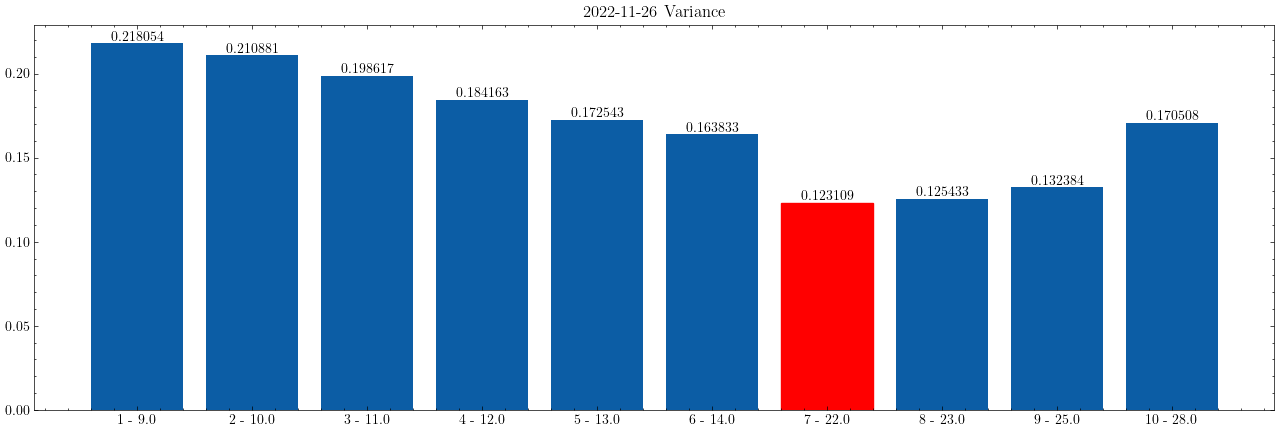

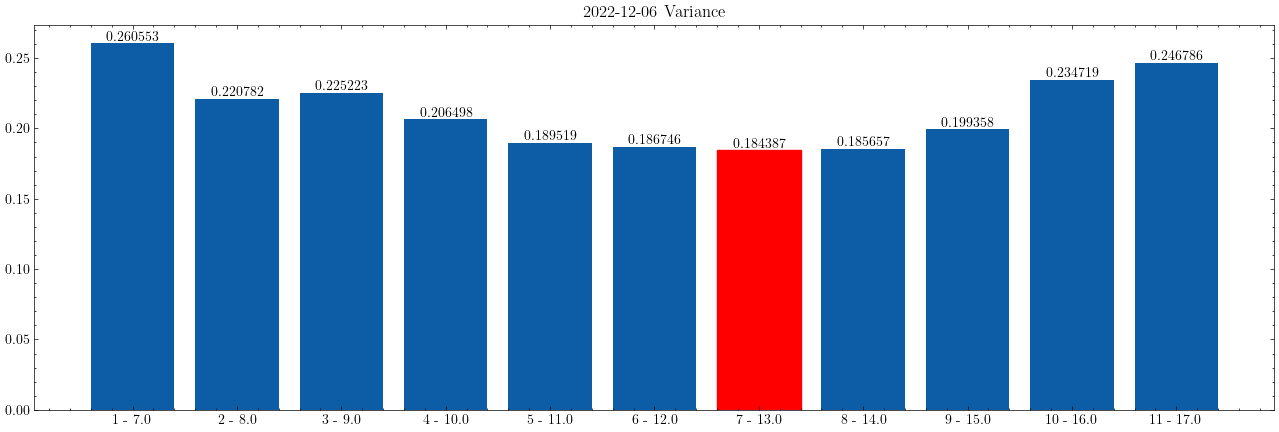

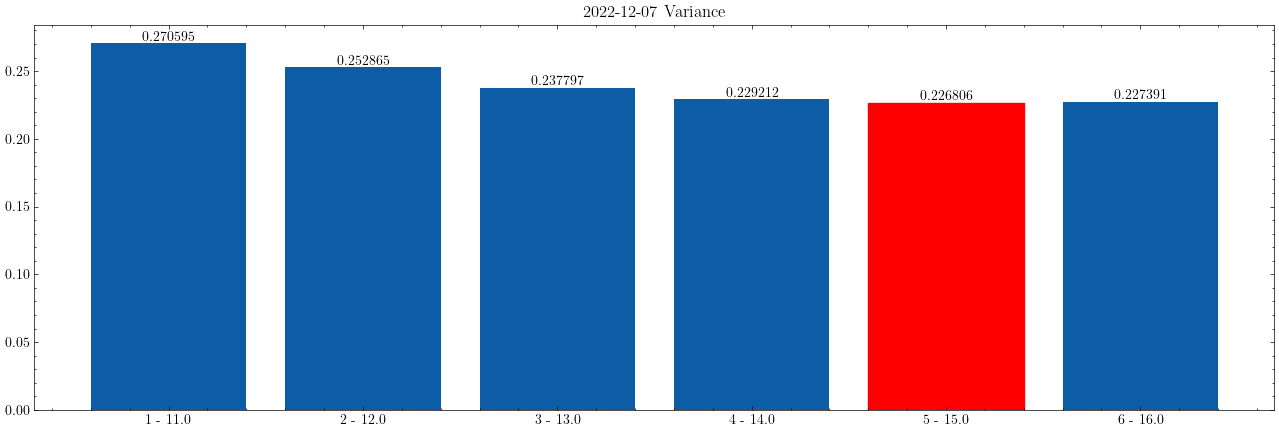

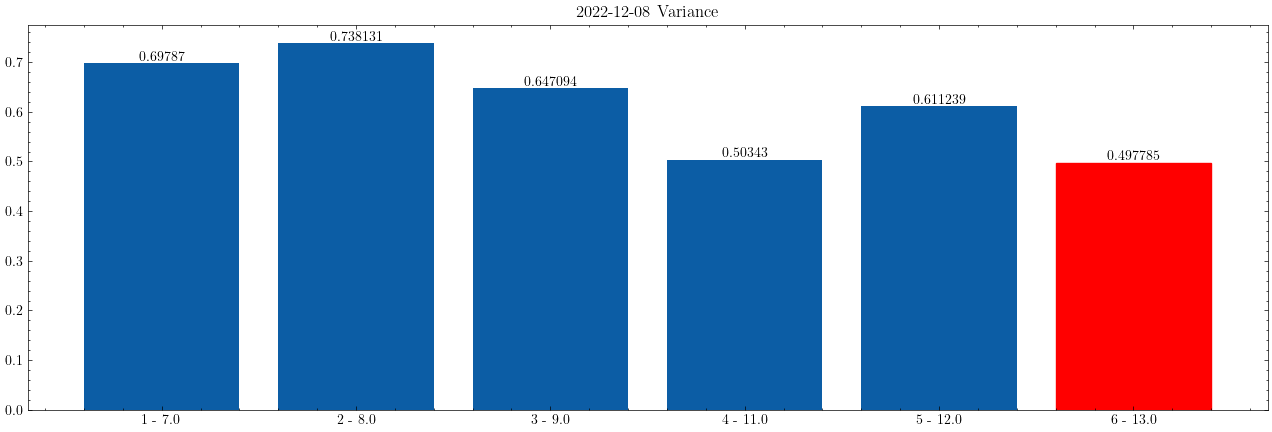

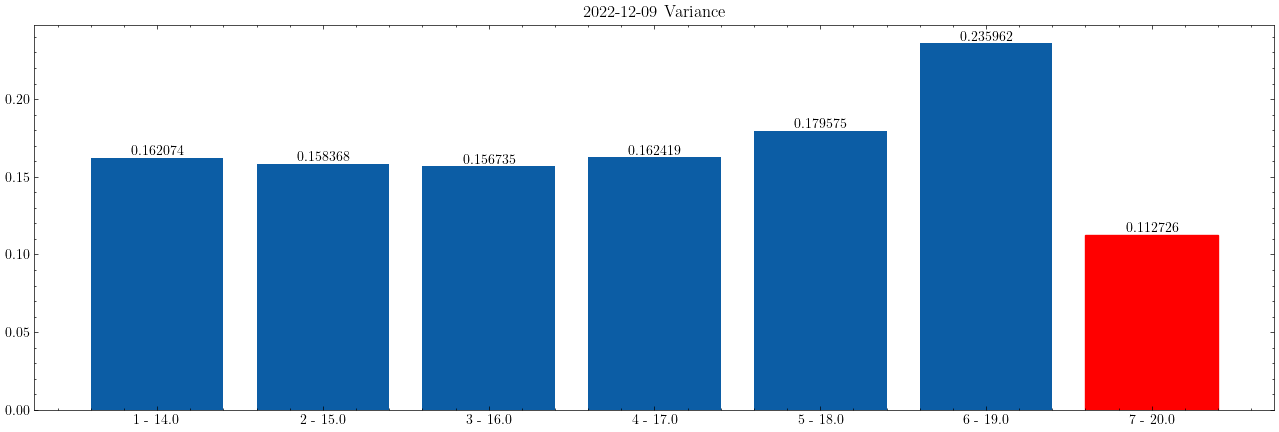

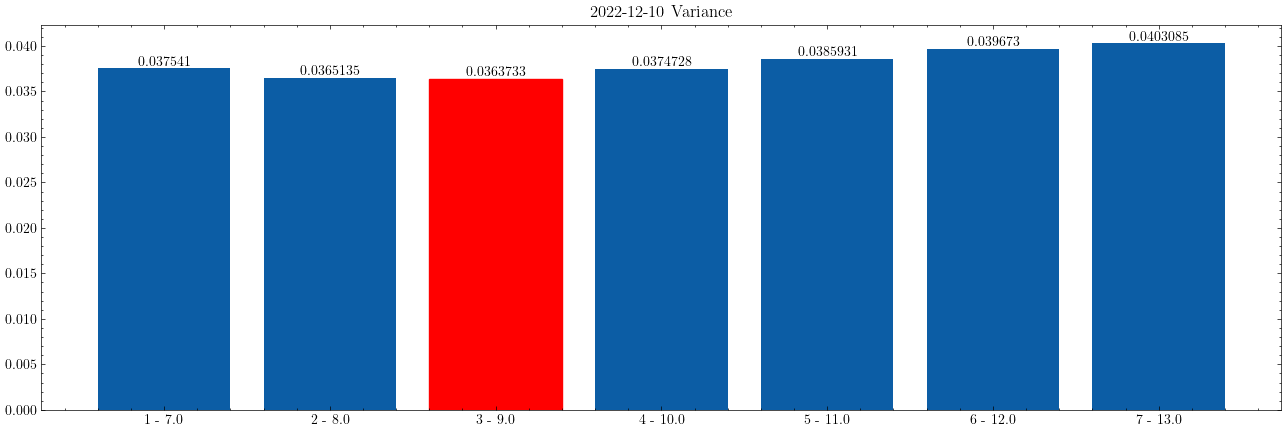

{'2022-10-21': '6',
 '2022-10-27': '3',
 '2022-11-05': '5',
 '2022-11-26': '7',
 '2022-12-06': '7',
 '2022-12-07': '5',
 '2022-12-08': '6',
 '2022-12-09': '7',
 '2022-12-10': '3'}

In [4]:
# examine standard deviation of ref. stars
	# will use for determining which aperture is actually best
import numpy as np

PLOT = True
OBSV_DATES_APERS = {}
for obsvDate, qphotDateResults in QPHOT_RESULTS.items():
    qphotDateResults = QPHOT_RESULTS[obsvDate]

    rapertIds = [c.replace('RAPERT', '') for c in qphotDateResults.columns if 'RAPERT' in c]
    obj_qphot = qphotDateResults[qphotDateResults['LID'] == 1]
    comp_qphot = qphotDateResults[qphotDateResults['LID'] == COMP_STAR_LID]

    rapertDataVariance: dict[str, float] = {}
    lowestVar = 1e5 # arbitrary high variance to initialize
    for rid in rapertIds:
        MAG_COL = f"MAG{rid}"
        rapertVar = np.var(obj_qphot[MAG_COL])
        if rapertVar < lowestVar:
            lowestVar = rapertVar
            OBSV_DATES_APERS[obsvDate] = rid
        rapertDataVariance[rid] = rapertVar

    if PLOT:
        fig, ax = plt.subplots(figsize=(16, 5))
        barList = ax.bar(rapertDataVariance.keys(), rapertDataVariance.values())
        barList[list(rapertDataVariance.keys()).index(OBSV_DATES_APERS[obsvDate])].set_color('r')
        ax.bar_label(barList)
        ax.set_xticklabels([f"{rid} - {qphotDateResults[f'RAPERT{rid}'].iloc[0]}" for rid in rapertDataVariance.keys()])
        plt.title(obsvDate + " Variance")
        plt.show()
OBSV_DATES_APERS

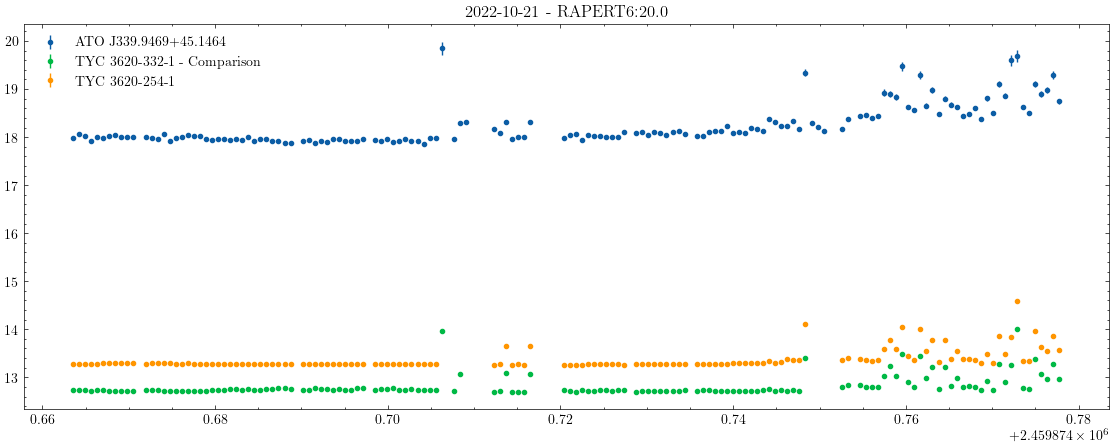

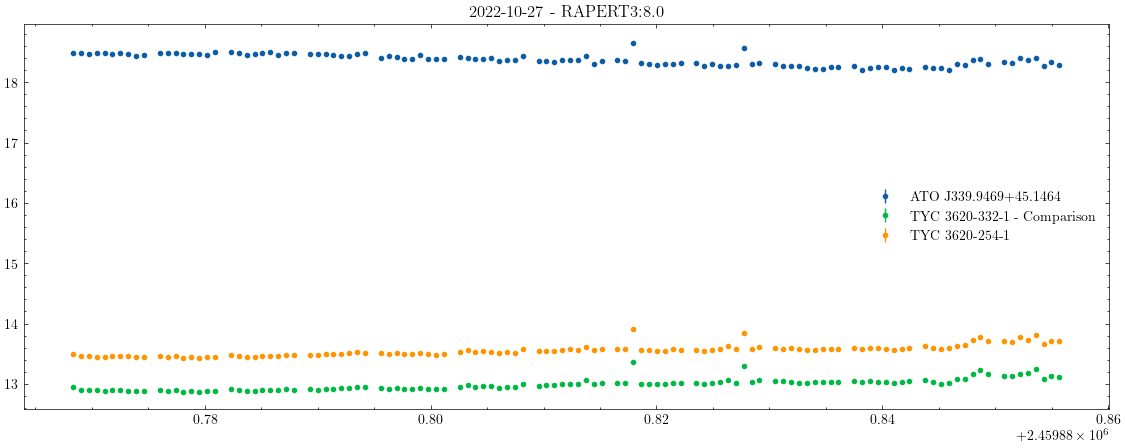

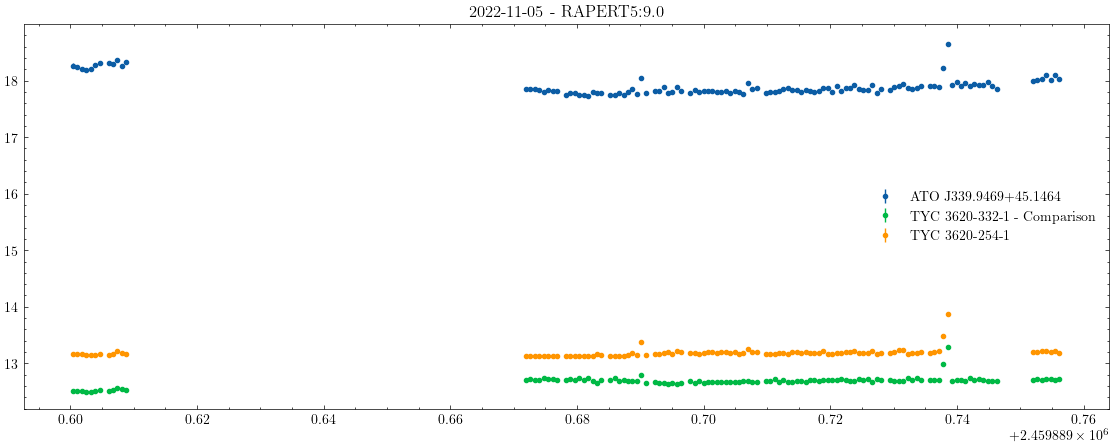

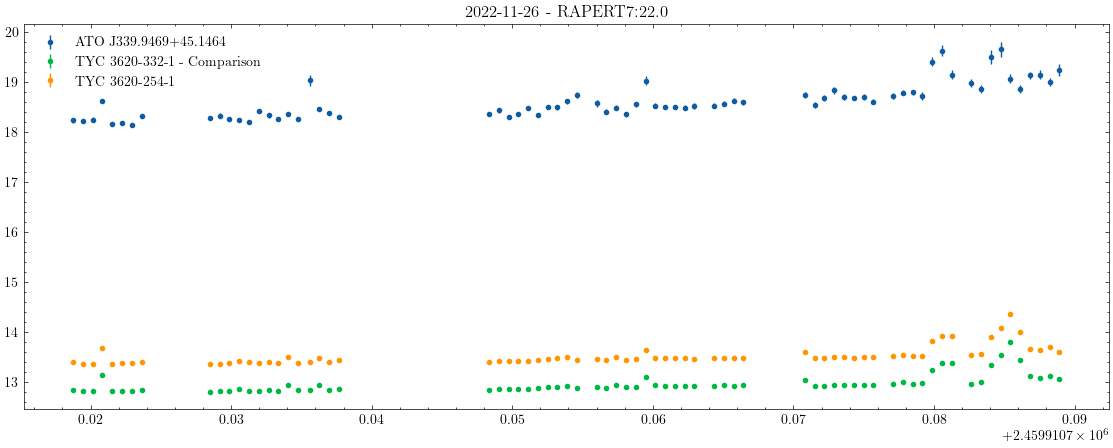

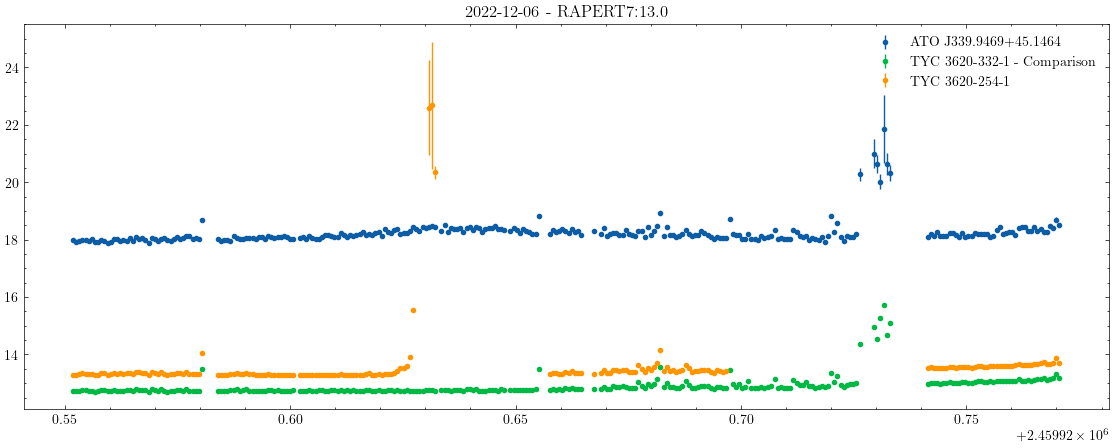

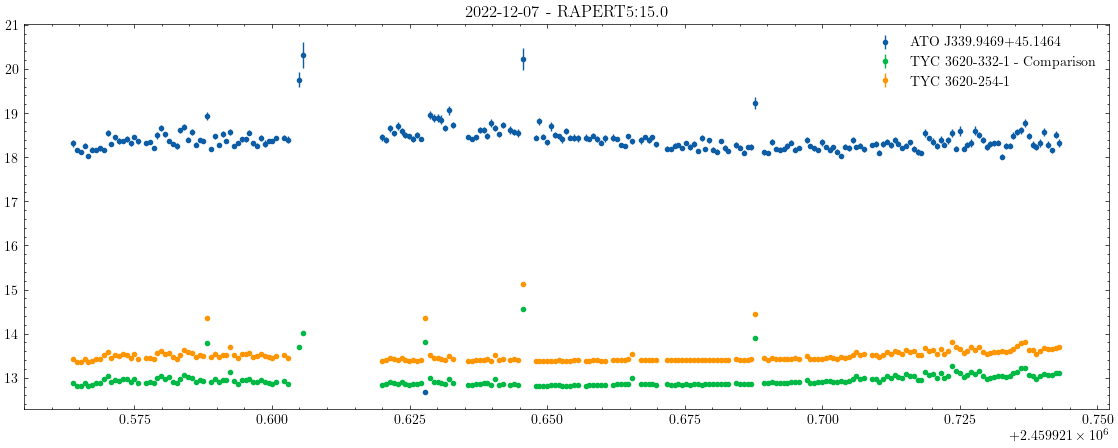

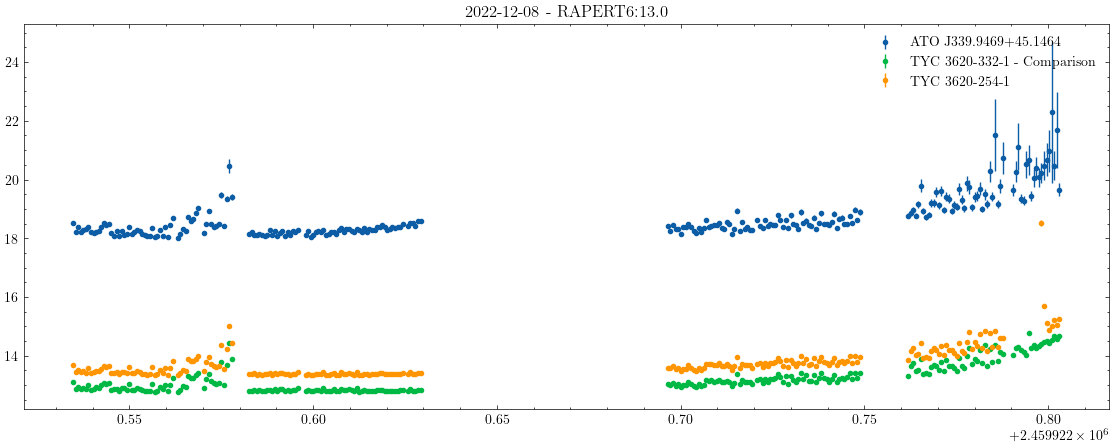

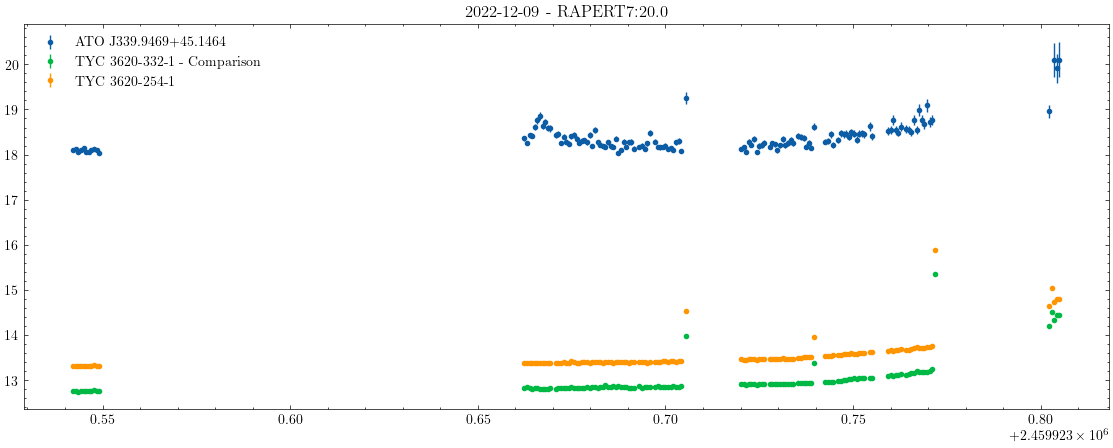

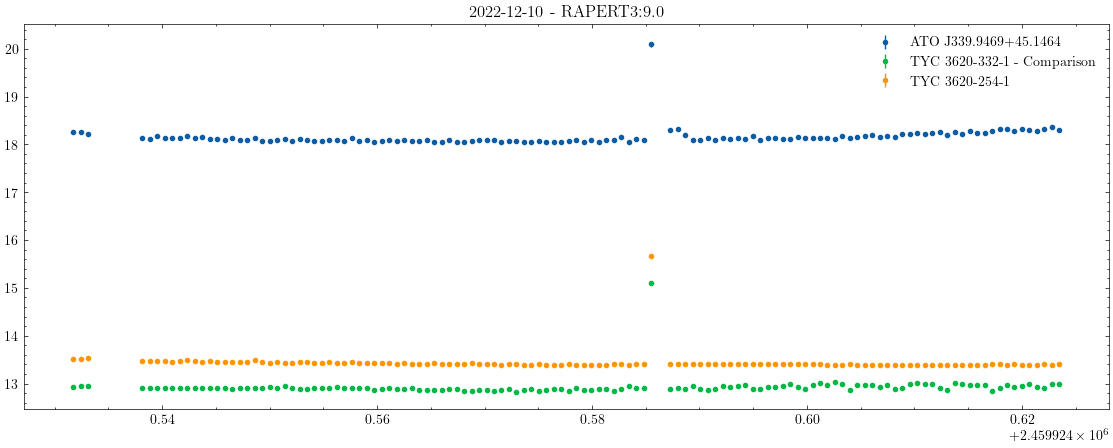

In [5]:
# spot checking above solution
# looks to be a decent fit; using variance score to choose which aperture to use

for obsvDate, rid in OBSV_DATES_APERS.items():
	qphotDateResults = QPHOT_RESULTS[obsvDate]
	obj_qphot = qphotDateResults[qphotDateResults['LID'] == 1]
	comp_qphot = qphotDateResults[qphotDateResults['LID'] == COMP_STAR_LID]
	alt_comp_qphot = qphotDateResults[qphotDateResults['LID'] == ALT_COMP_LID]

	plt.figure(figsize=(14,5))
	plt.errorbar(obj_qphot['julianDate'], obj_qphot[f'MAG{rid}'], obj_qphot[f'MERR{rid}'], label=STAR_LIDS[1], fmt='.')
	plt.errorbar(comp_qphot['julianDate'], comp_qphot[f'MAG{rid}'], comp_qphot[f'MERR{rid}'], label=f"{STAR_LIDS[COMP_STAR_LID]} - Comparison", fmt='.')
	plt.errorbar(alt_comp_qphot['julianDate'], alt_comp_qphot[f'MAG{rid}'], alt_comp_qphot[f'MERR{rid}'], label=STAR_LIDS[ALT_COMP_LID], fmt='.')
	plt.title(f"{obsvDate} - RAPERT{rid}:{qphotDateResults[f'RAPERT{rid}'].iloc[0]}")
	plt.legend()
	plt.show()

143


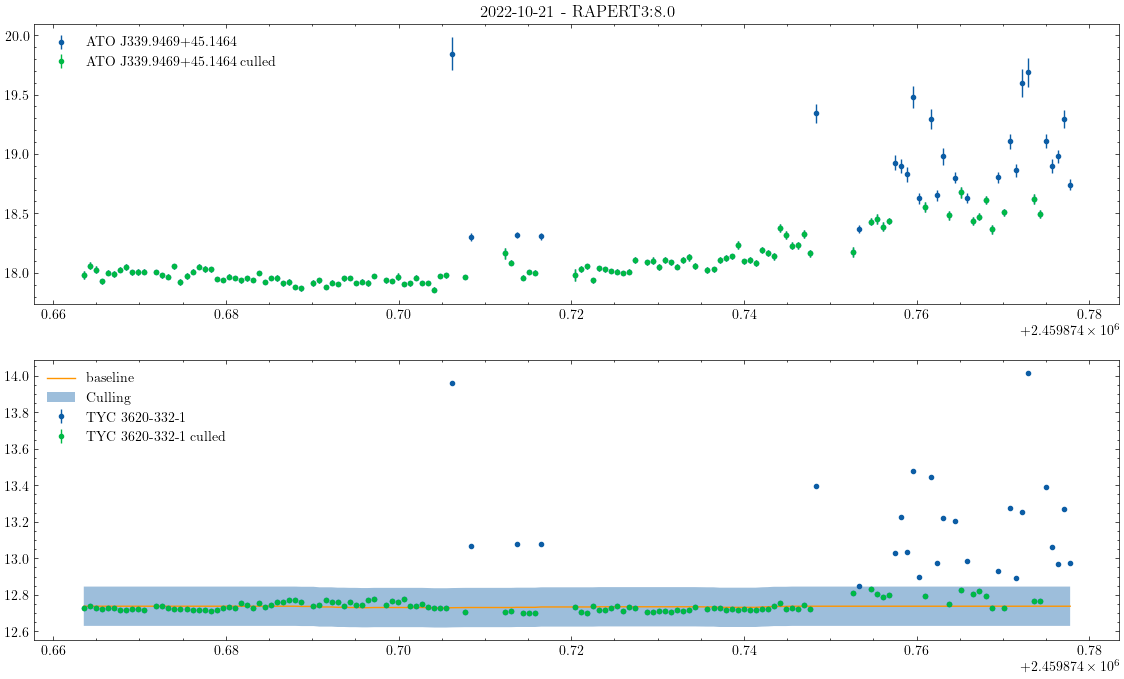

114


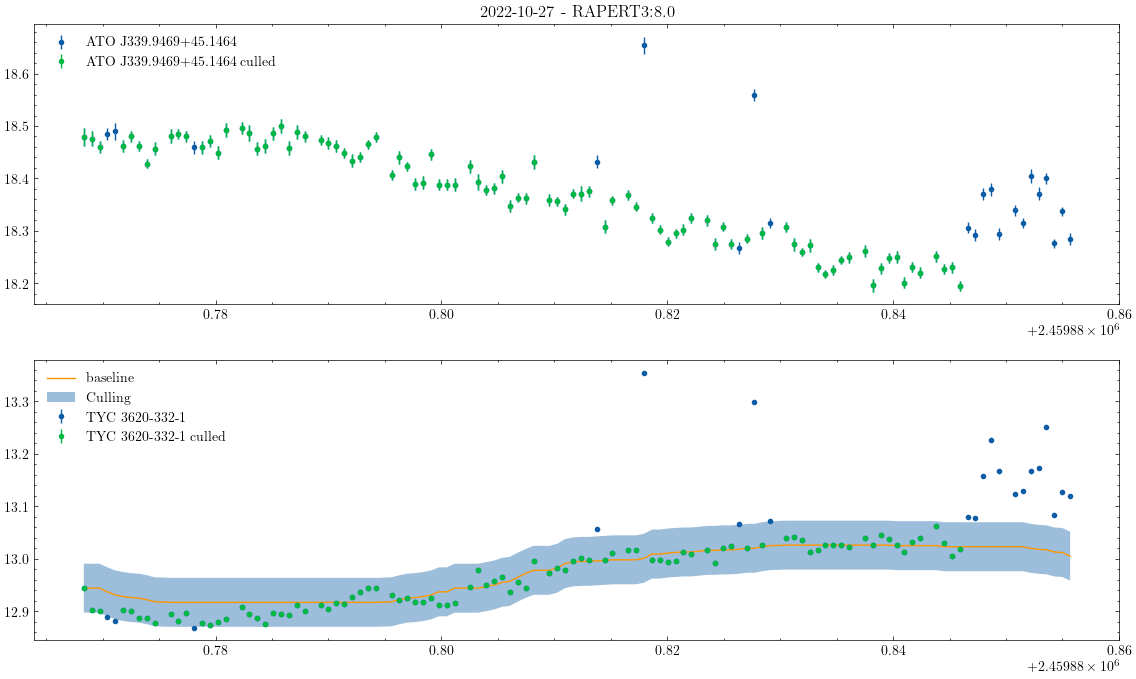

119


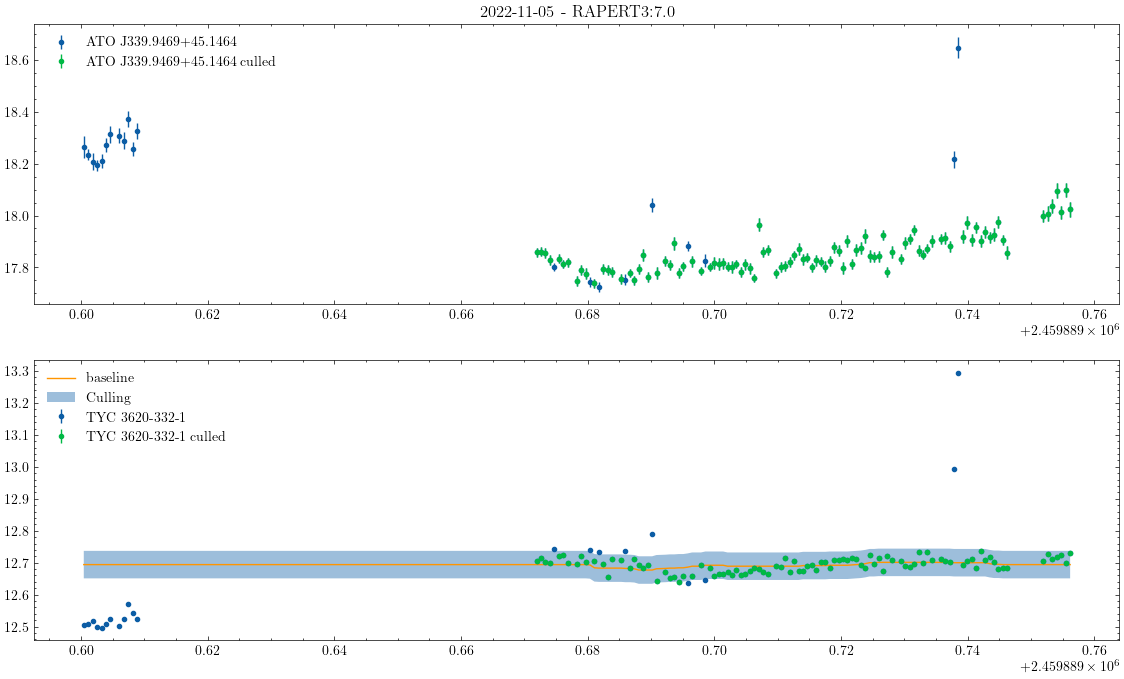

72


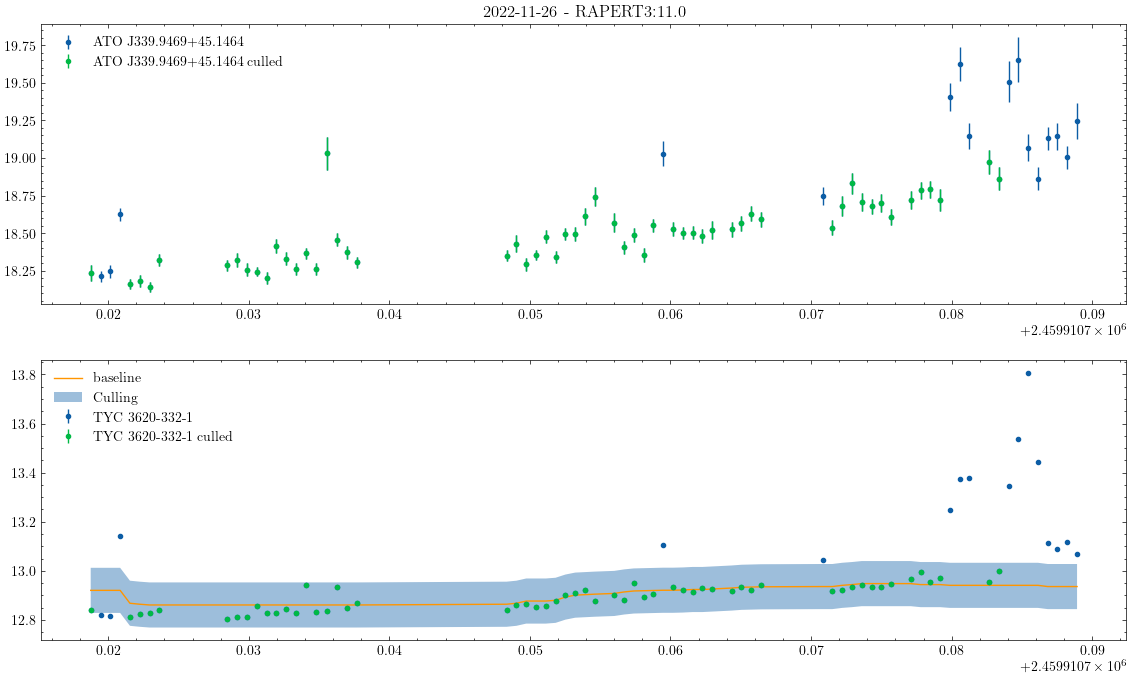

286


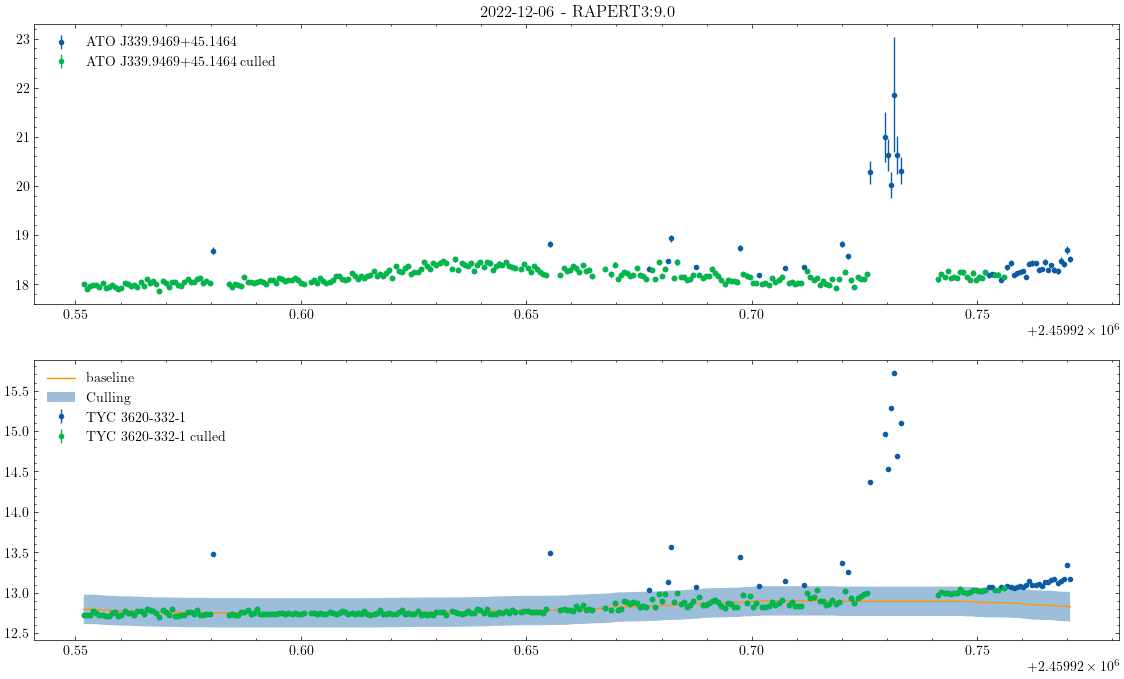

218


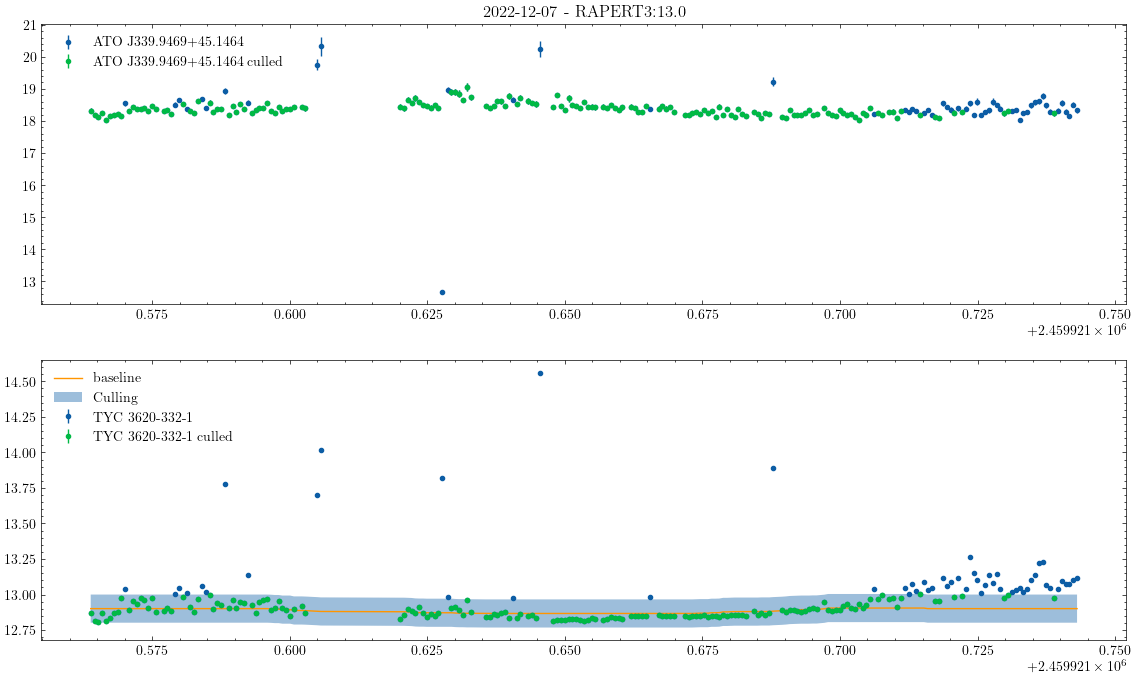

258


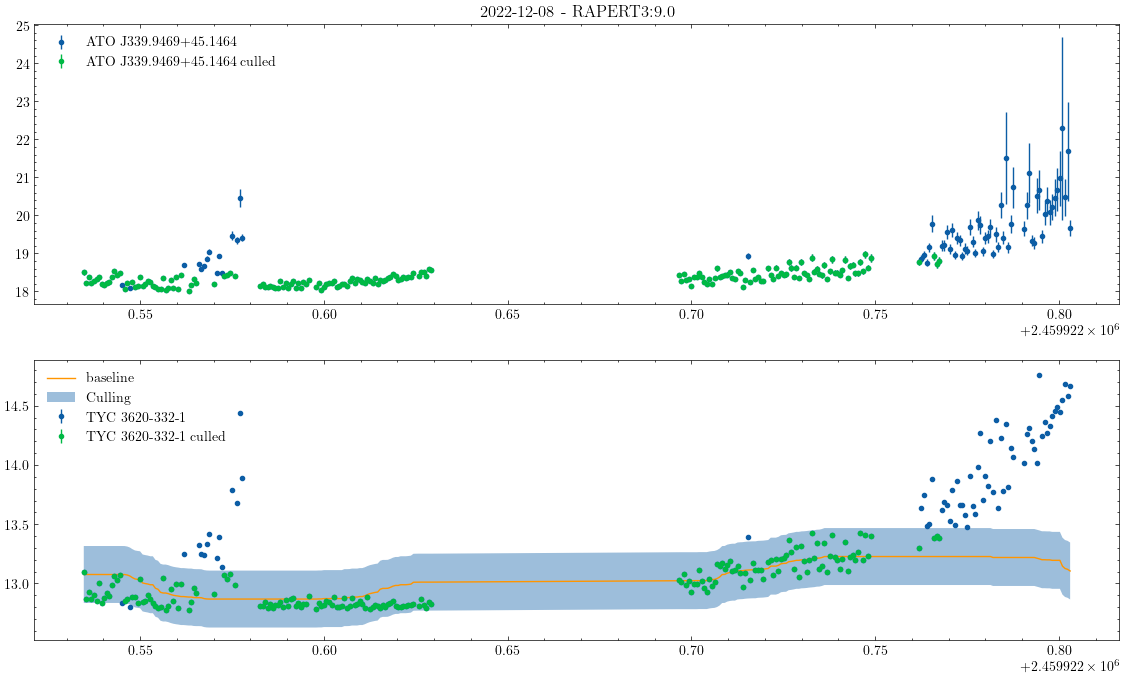

137


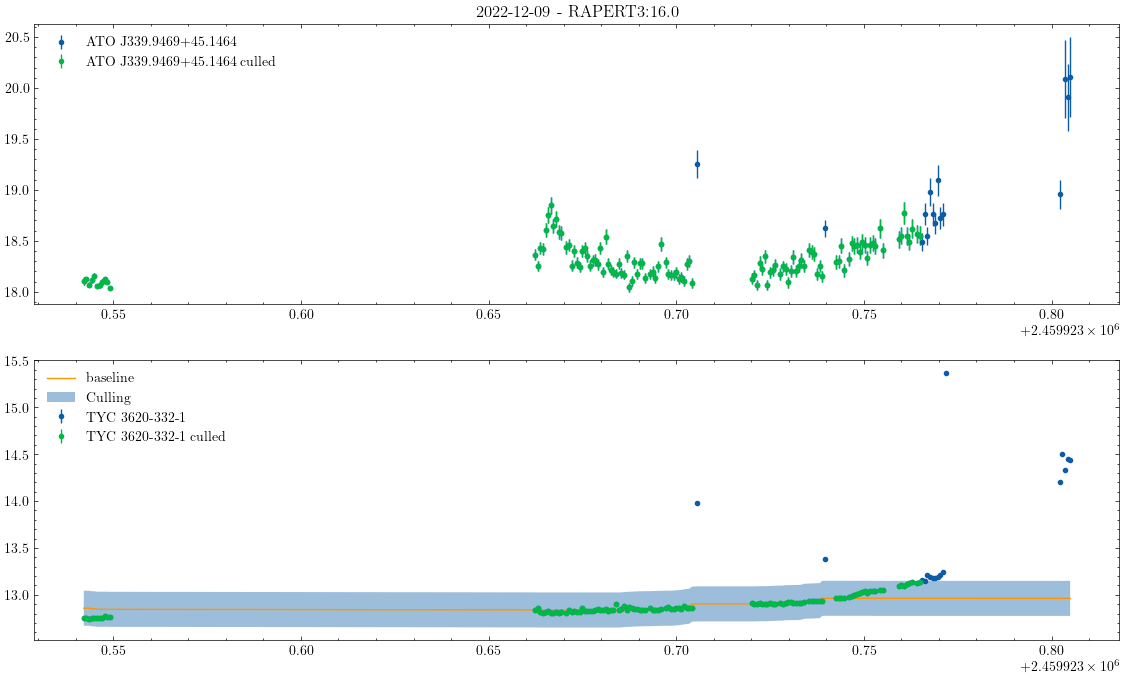

125


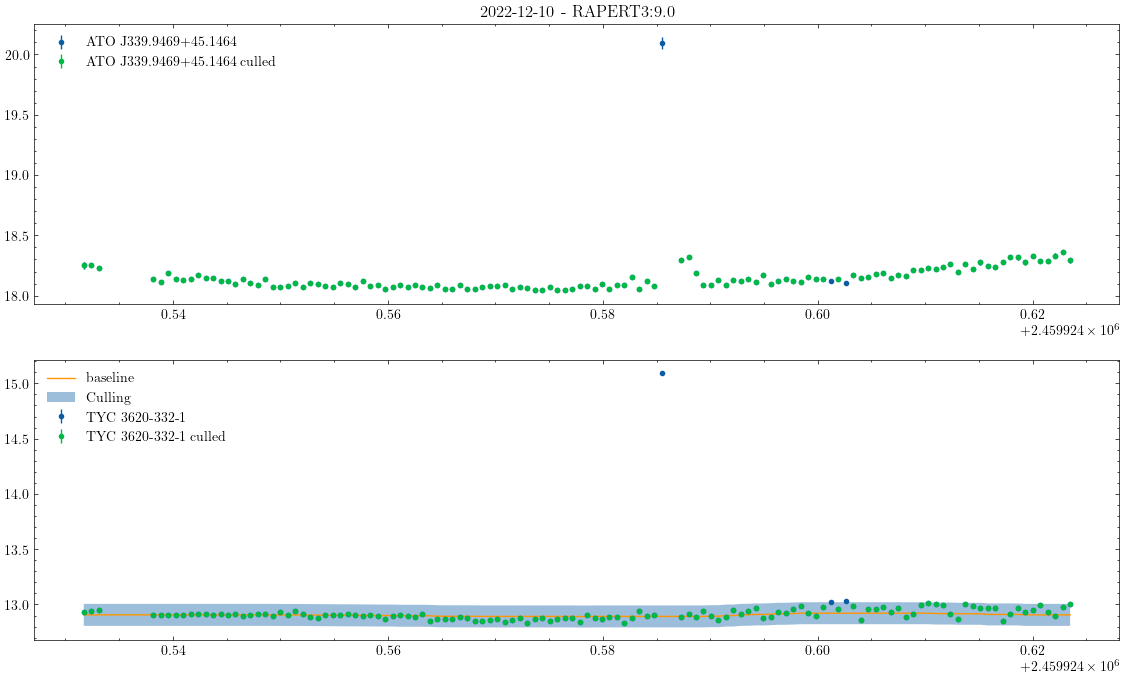

In [6]:
from scipy.ndimage import median_filter

CULLED_FLTRS = {}
for obsvDate, rapertId in OBSV_DATES_APERS.items():
	qphotDateResults = QPHOT_RESULTS[obsvDate]
	obj_qphot = qphotDateResults[qphotDateResults['LID'] == 1].reset_index(drop=True)
	comp_qphot = qphotDateResults[qphotDateResults['LID'] == COMP_STAR_LID].reset_index(drop=True)
	
	obj_qphot = obj_qphot[~np.isnan(comp_qphot[f'MAG{rapertId}'])]
	comp_qphot = comp_qphot[~np.isnan(comp_qphot[f'MAG{rapertId}'])]

	print(len(obj_qphot))

	initSigma = np.std(comp_qphot[f'MAG{rapertId}'])
	xi_low = 0.5
	xi_high = 0.5
	baseline = median_filter(comp_qphot[f'MAG{rapertId}'], size=round(len(comp_qphot)/1.7), mode='constant', cval=np.median(comp_qphot[f'MAG{rapertId}'].to_numpy()))

	fltrLow = (comp_qphot[f'MAG{rapertId}'] - baseline > (-xi_low)*initSigma)
	fltrHigh = (comp_qphot[f'MAG{rapertId}'] - baseline < xi_high*initSigma) 
	fltr = fltrLow & fltrHigh

	CULLED_FLTRS[obsvDate] = fltr.copy()

	fig, axs = plt.subplots(2, 1, figsize=(14,8))
	axs[0].errorbar(obj_qphot['julianDate'], obj_qphot[f'MAG{rapertId}'], obj_qphot[f'MERR{rapertId}'], label=STAR_LIDS[1], fmt='.')
	axs[0].errorbar(obj_qphot['julianDate'][fltr], obj_qphot[f'MAG{rapertId}'][fltr], obj_qphot[f'MERR{rapertId}'][fltr], label=f"{STAR_LIDS[1]} culled", fmt='.')
	
	axs[1].errorbar(comp_qphot['julianDate'], comp_qphot[f'MAG{rapertId}'], comp_qphot[f'MERR{rapertId}'], label=STAR_LIDS[COMP_STAR_LID], fmt='.')
	axs[1].errorbar(comp_qphot['julianDate'][fltr], comp_qphot[f'MAG{rapertId}'][fltr], comp_qphot[f'MERR{rapertId}'][fltr], label=f"{STAR_LIDS[COMP_STAR_LID]} culled", fmt='.')
	
	axs[1].plot(comp_qphot['julianDate'], baseline, label='baseline')
	axs[1].fill_between(comp_qphot['julianDate'], baseline - (xi_low*initSigma), baseline + (xi_high*initSigma), alpha=0.4, label="Culling")

	[ax.legend(loc='upper left') for ax in axs]
	axs[0].set_title(f"{obsvDate} - RAPERT{rid}:{qphotDateResults[f'RAPERT{rid}'].iloc[0]}")
	plt.show()

2022-10-21 - Culled 26 points
Area = 1256.977
Std dev. = 25.70022
Nsky = 2967


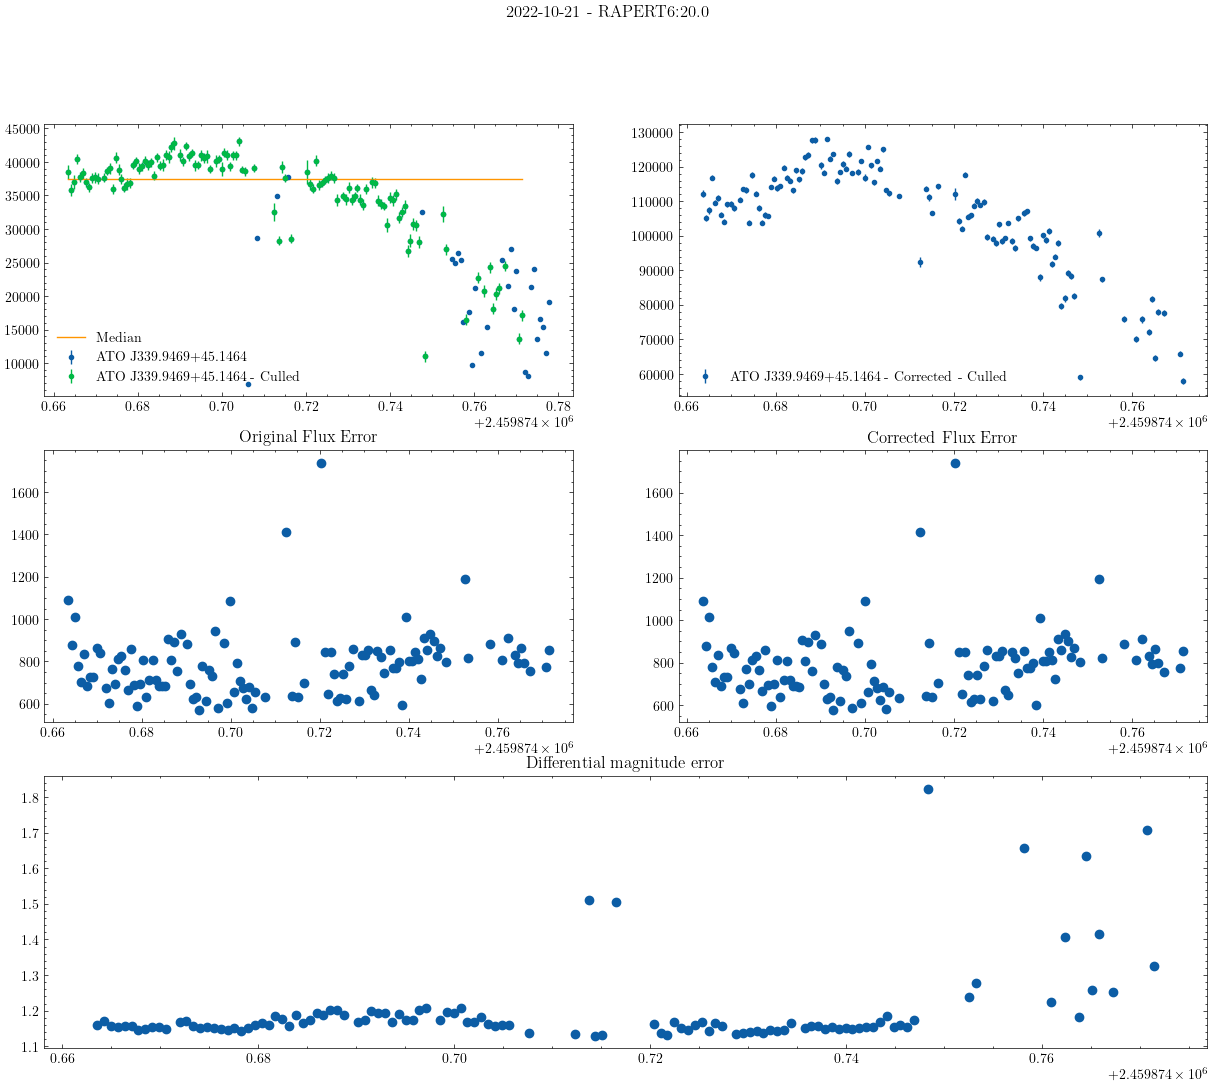

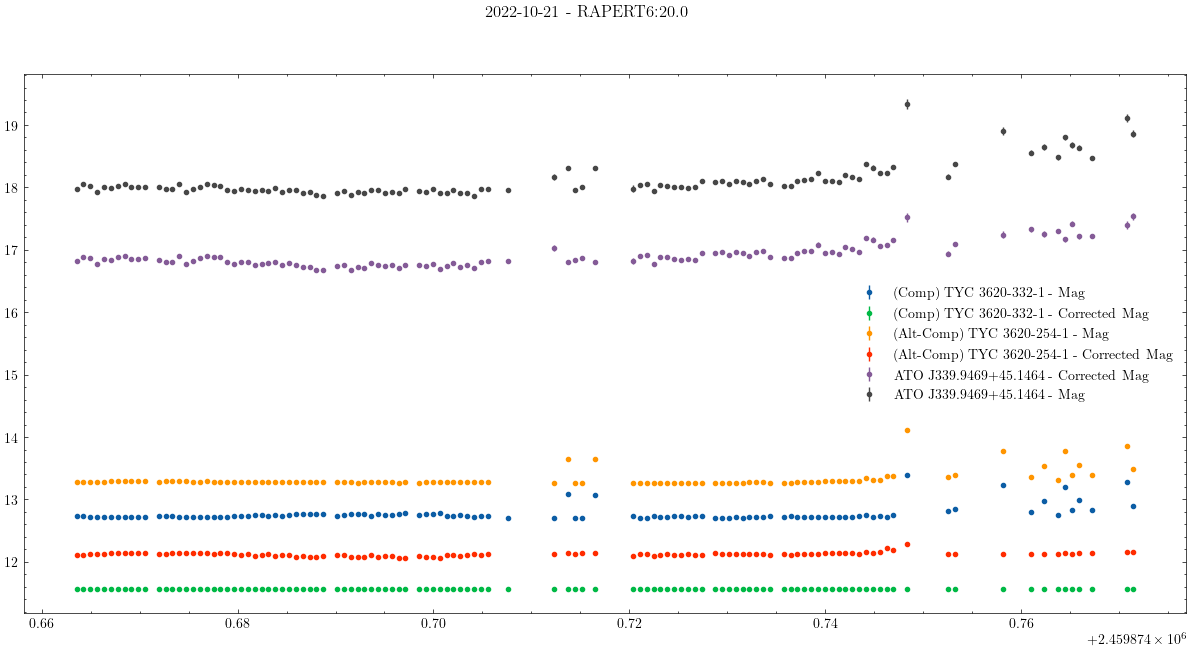

2022-10-27 - Culled 21 points
Area = 200.9015
Std dev. = 26.28483
Nsky = 2828


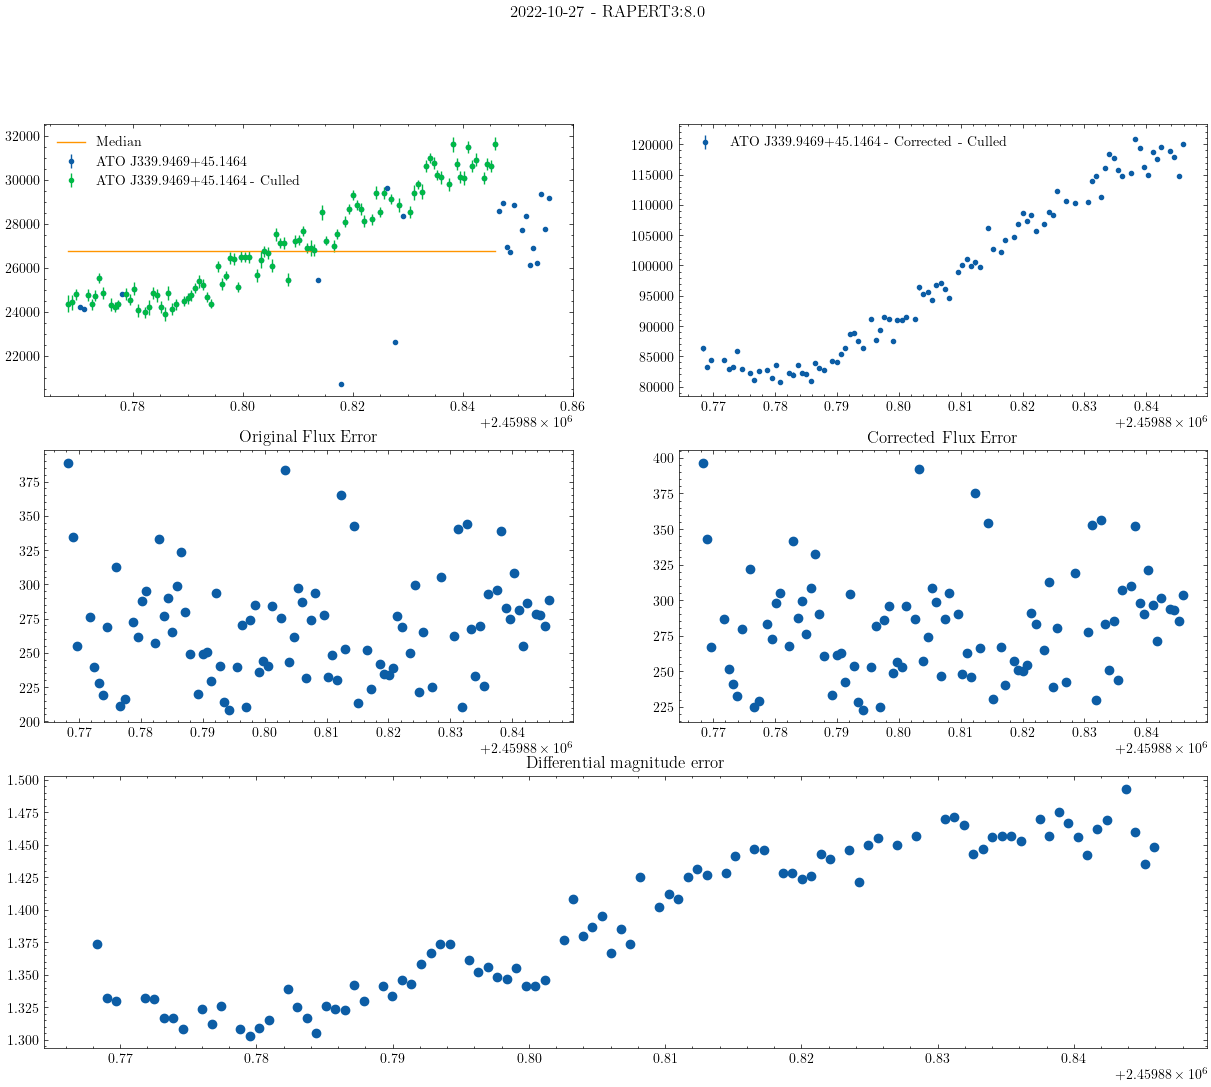

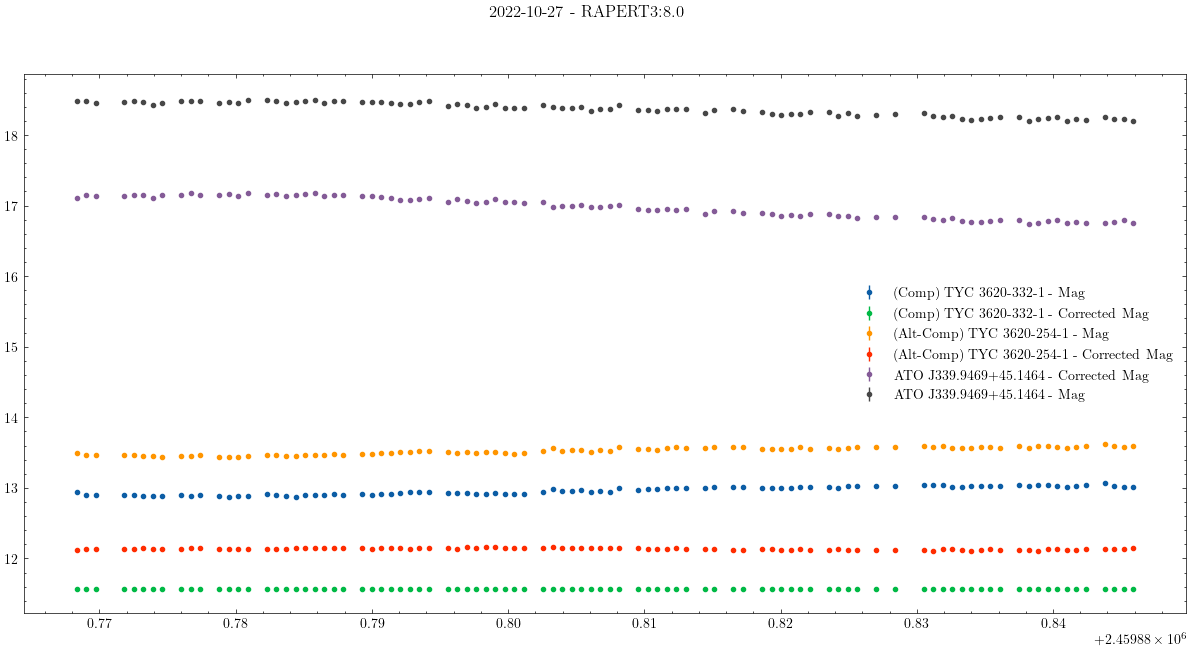

2022-11-05 - Culled 21 points
Area = 254.9198
Std dev. = 44.0473
Nsky = 3560


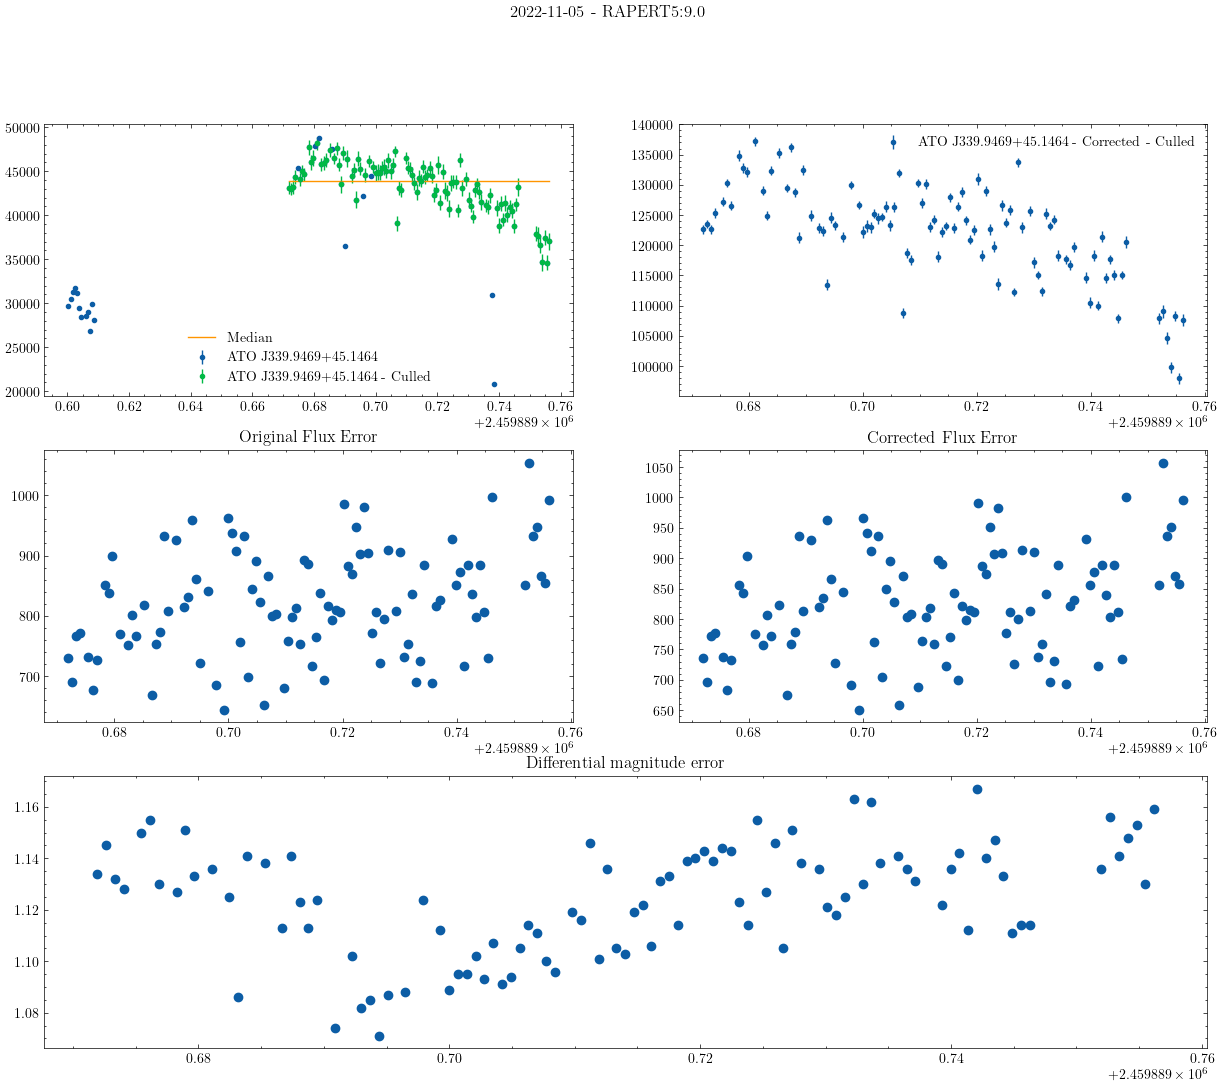

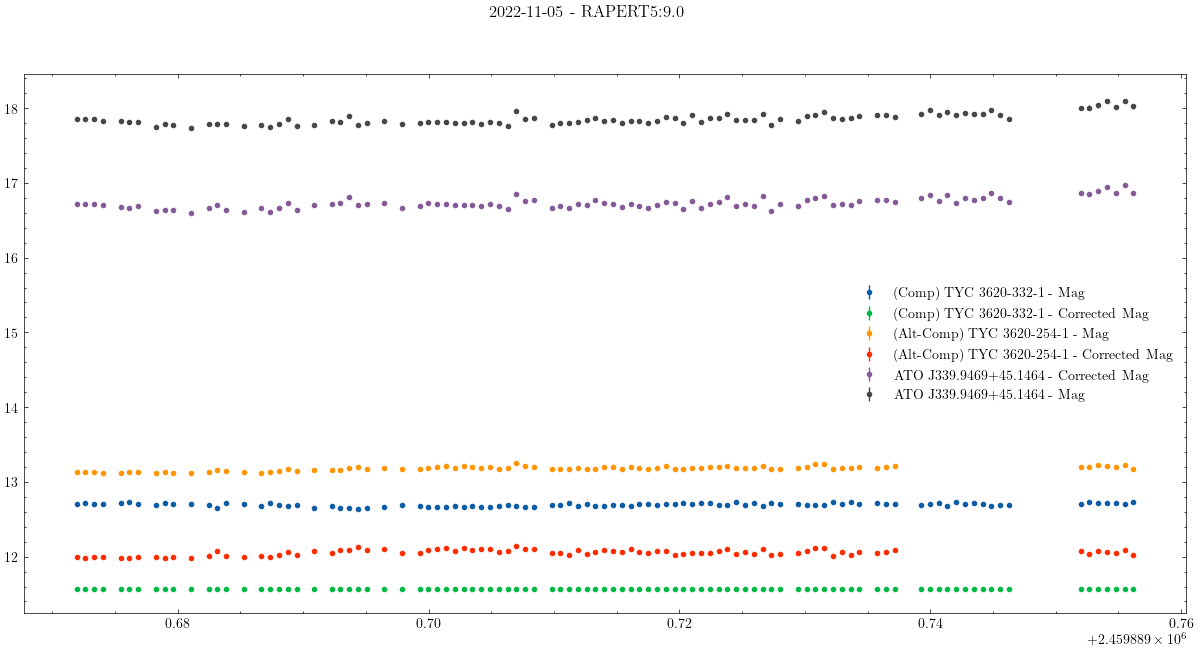

2022-11-26 - Culled 16 points
Area = 1520.831
Std dev. = 31.65167
Nsky = 3457


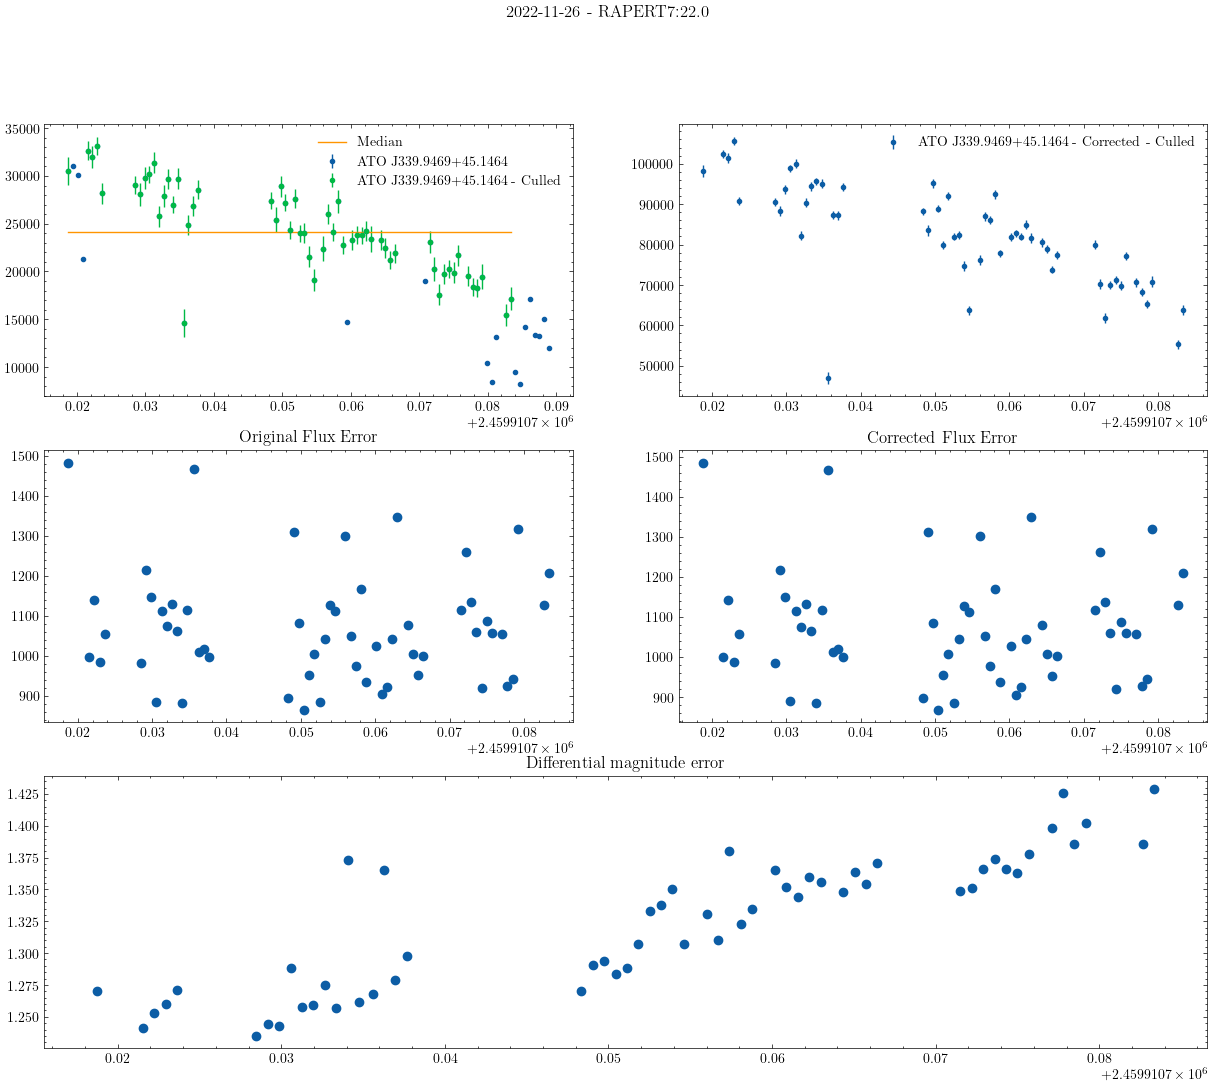

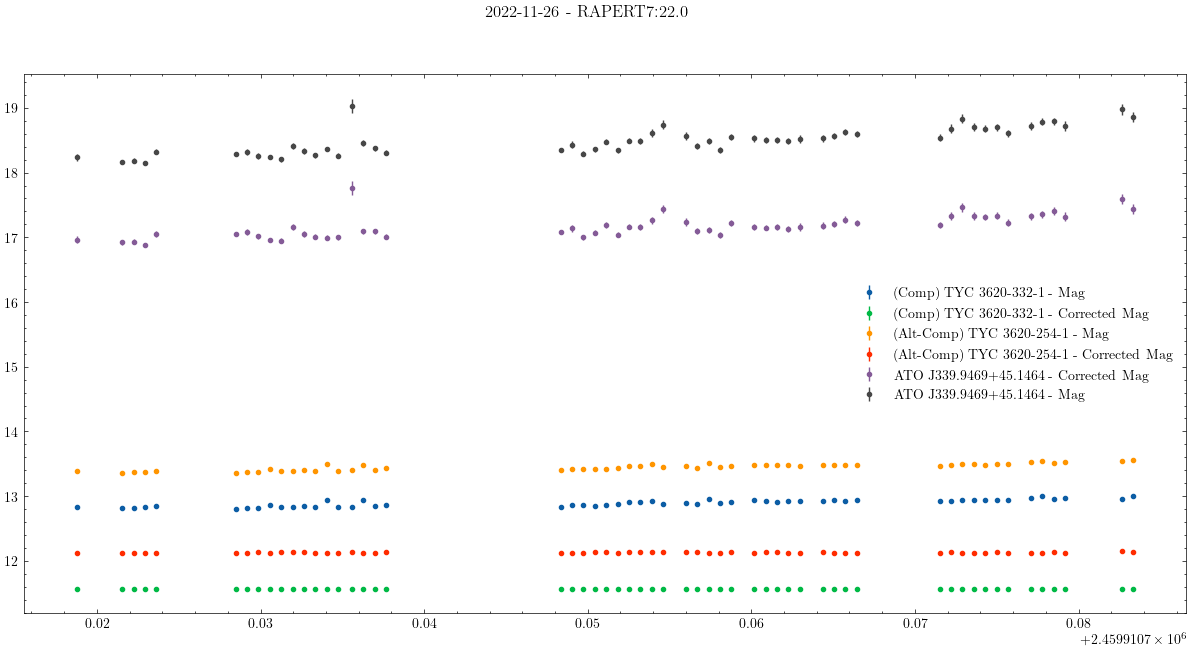

2022-12-06 - Culled 43 points
Area = 530.8476
Std dev. = 49.93329
Nsky = 2301


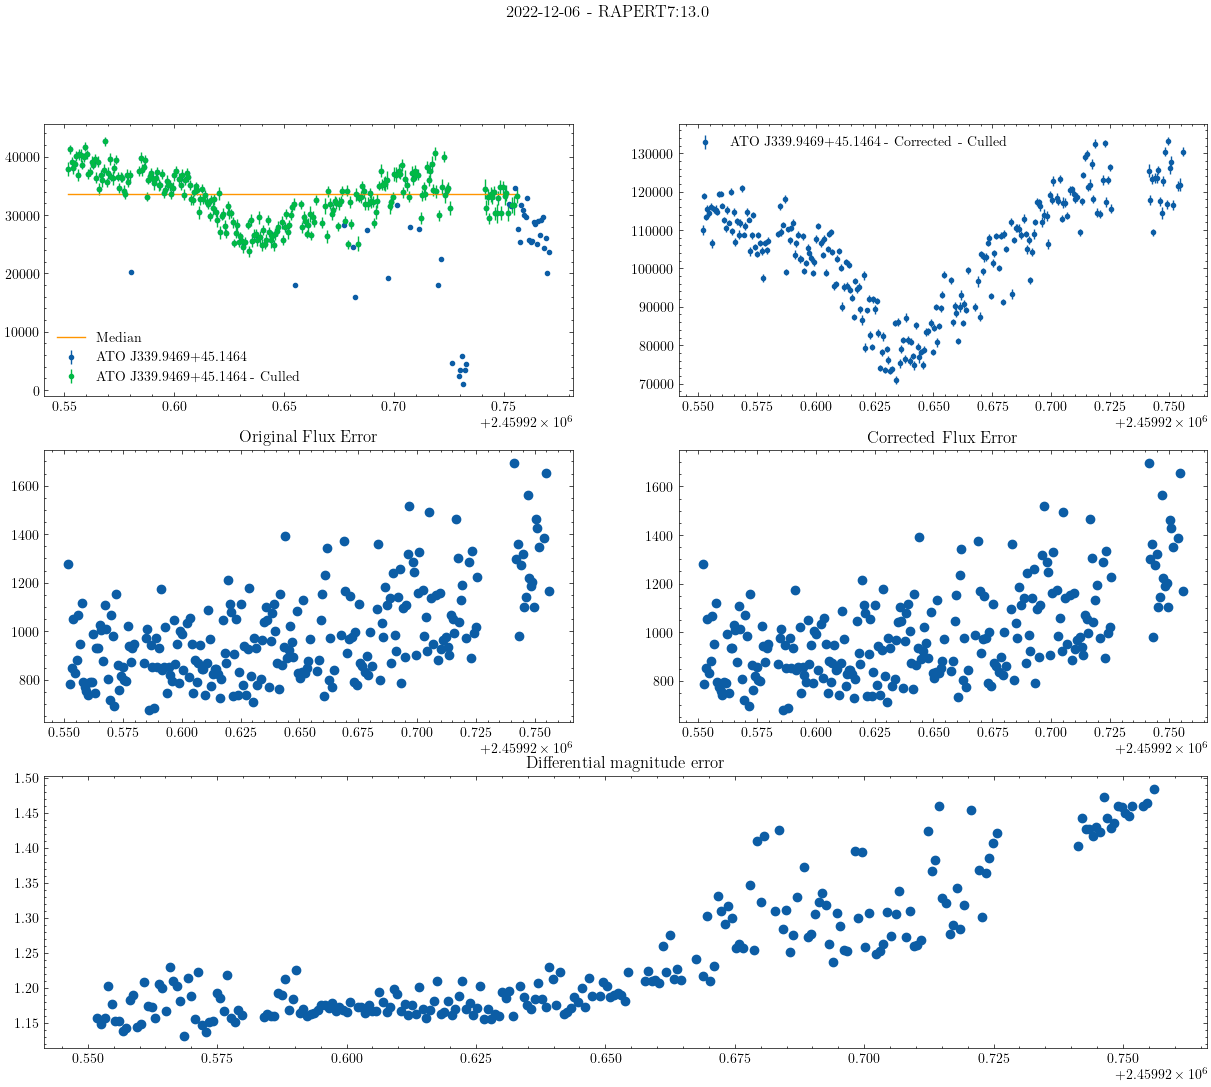

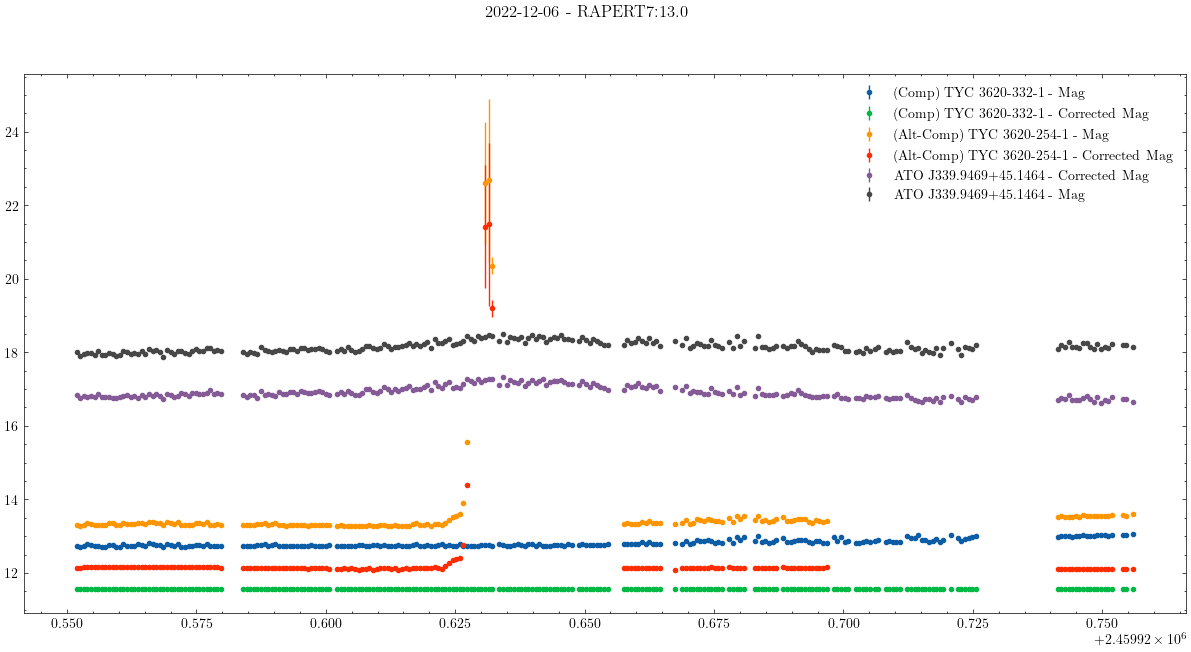

2022-12-07 - Culled 55 points
Area = 707.028
Std dev. = 69.71195
Nsky = 4446


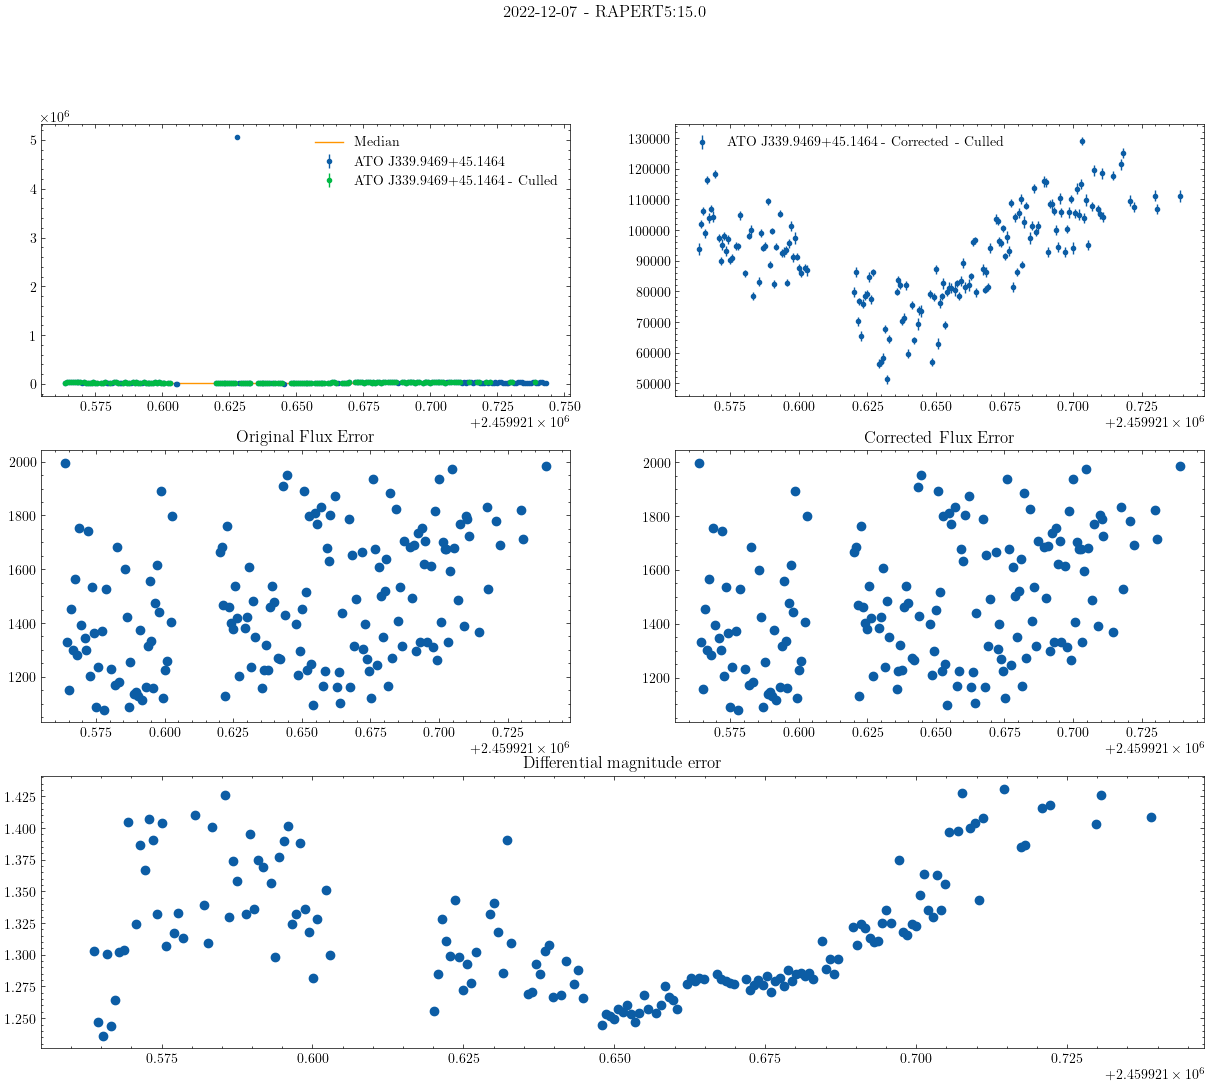

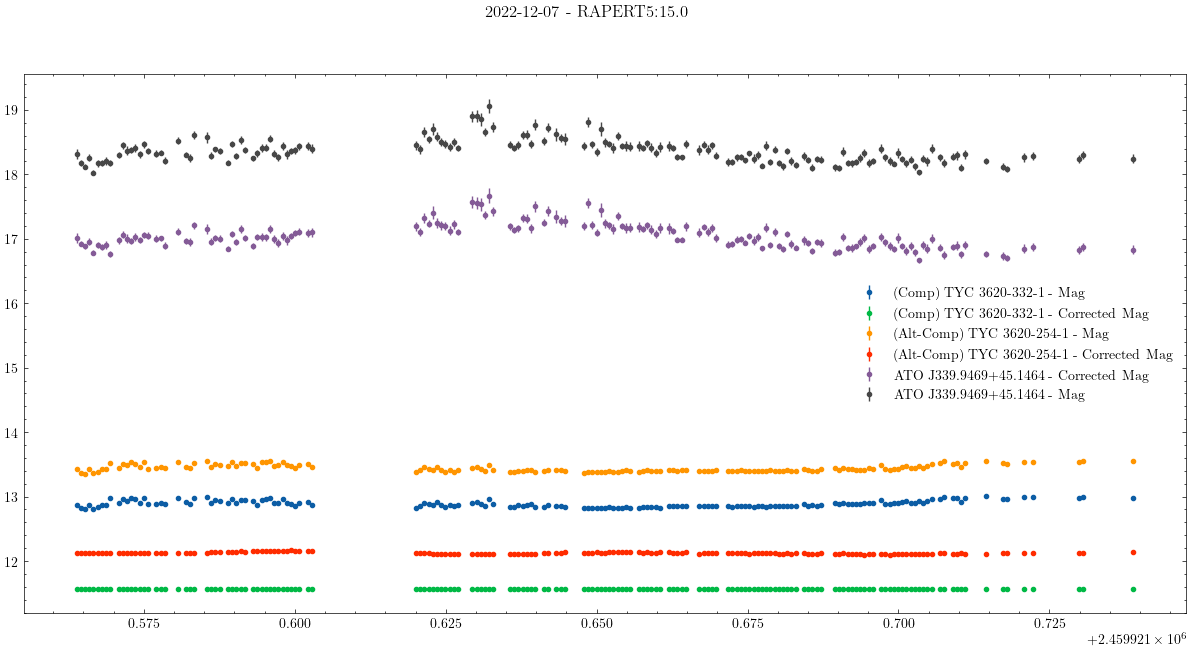

2022-12-08 - Culled 69 points
Area = 531.0261
Std dev. = 47.27938
Nsky = 939


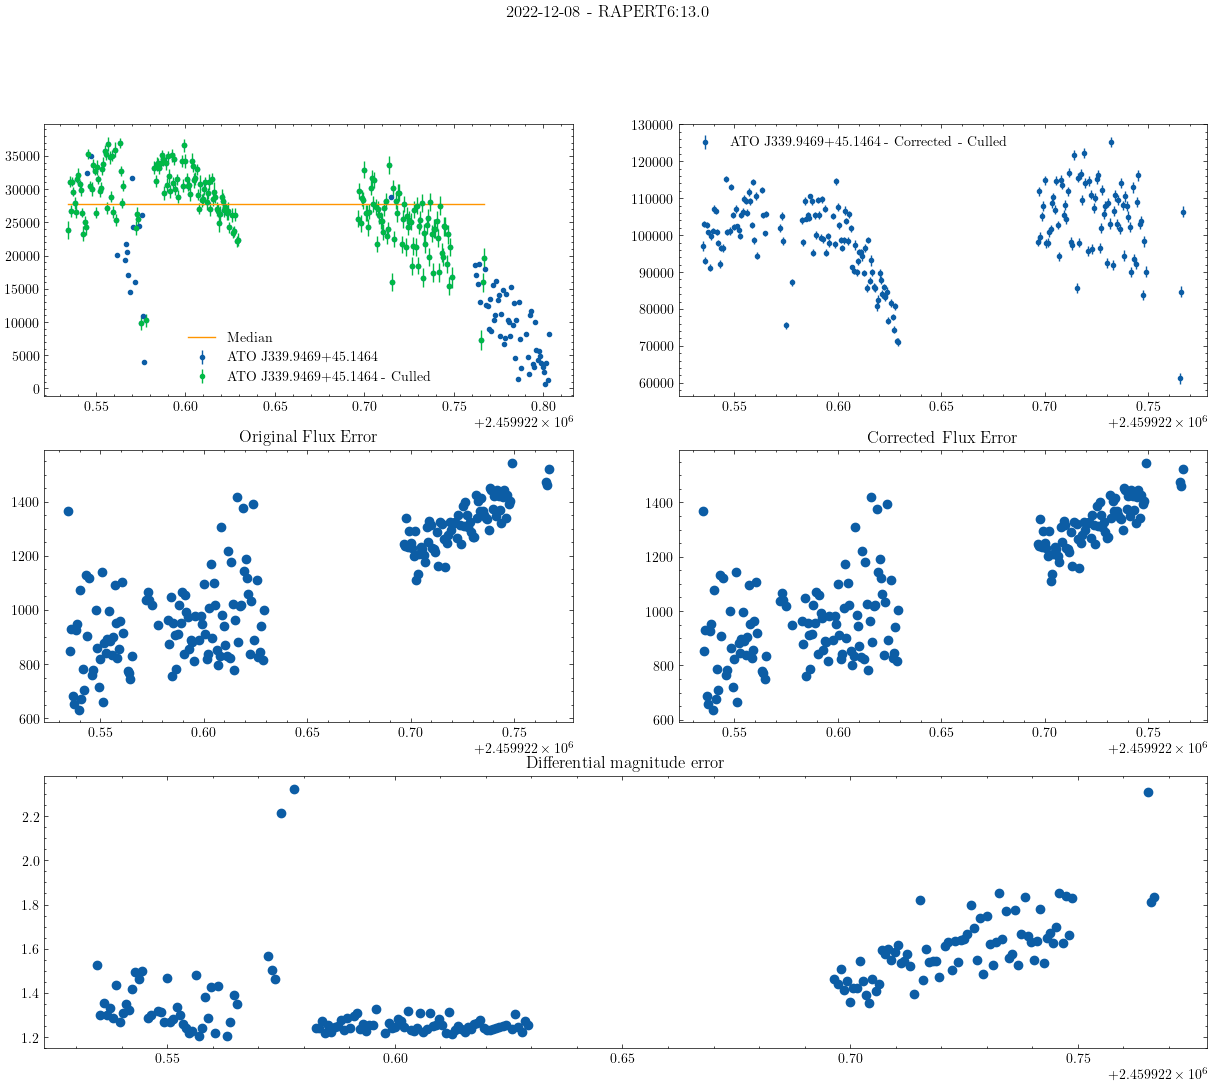

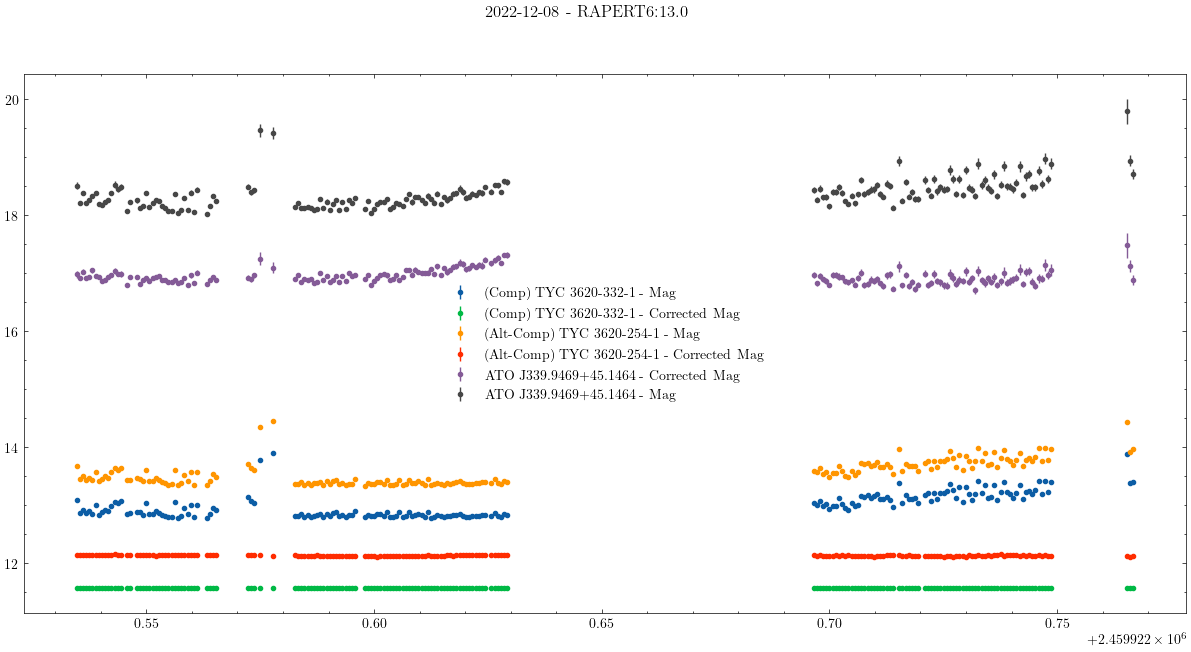

2022-12-09 - Culled 17 points
Area = 1256.579
Std dev. = 28.72972
Nsky = 5403


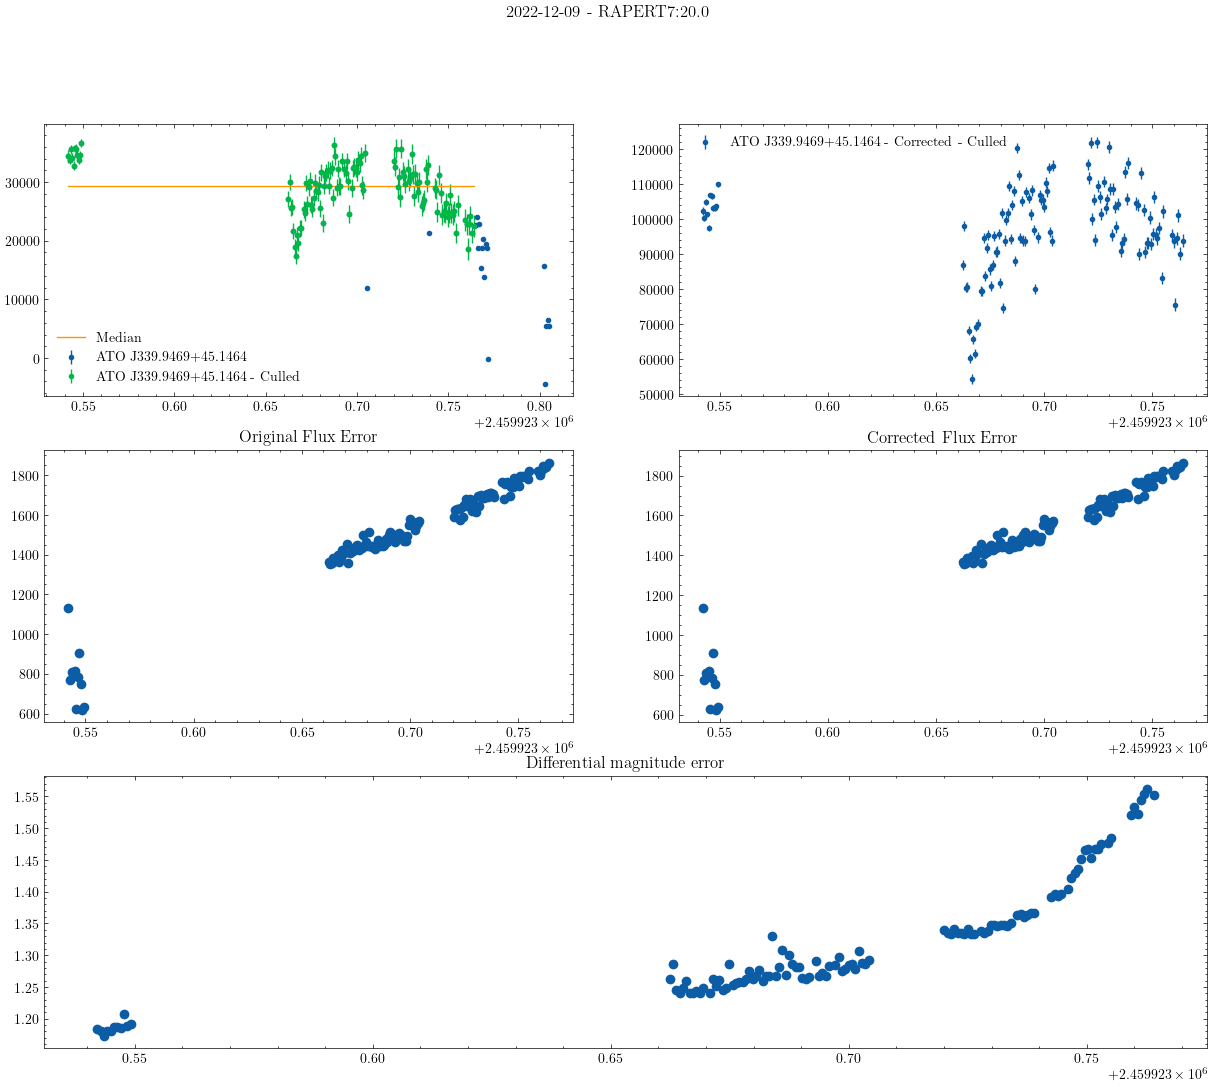

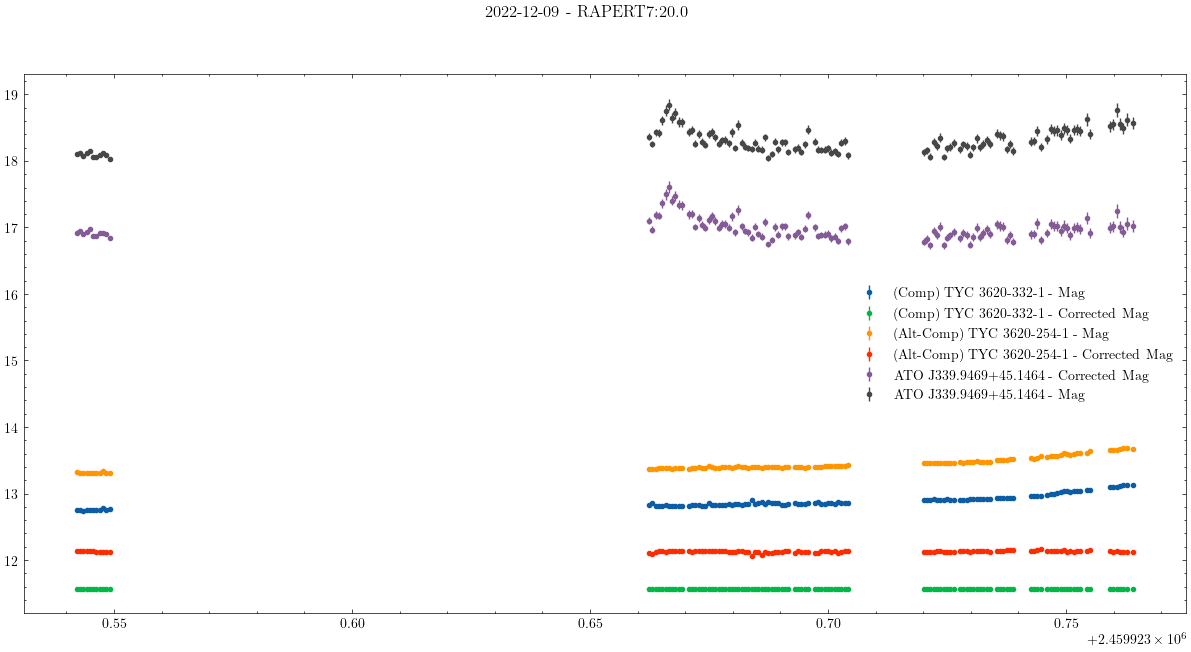

2022-12-10 - Culled 3 points
Area = 254.5465
Std dev. = 43.36491
Nsky = 1563


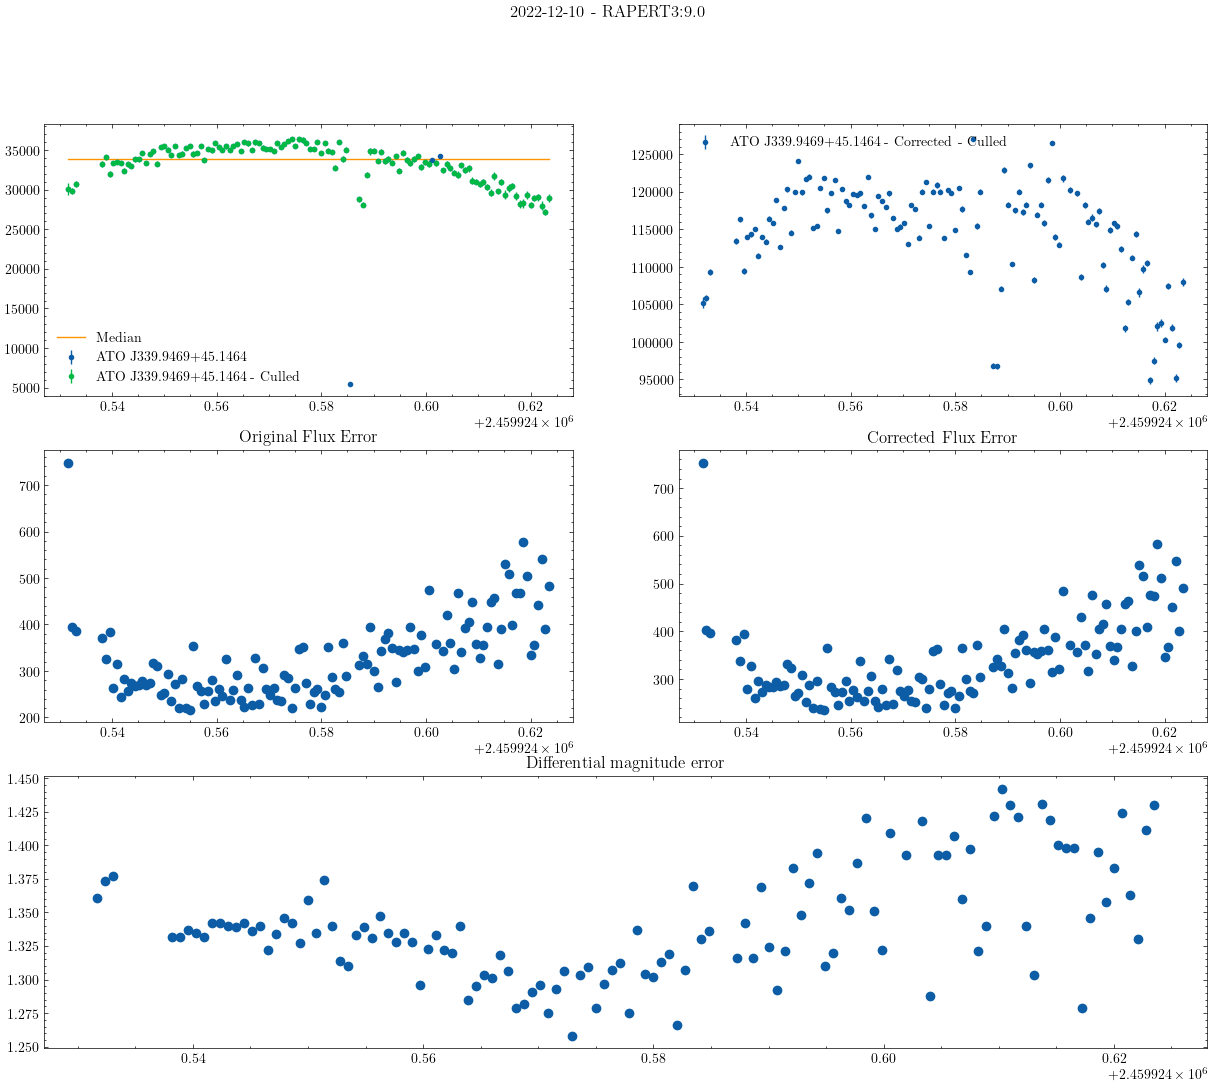

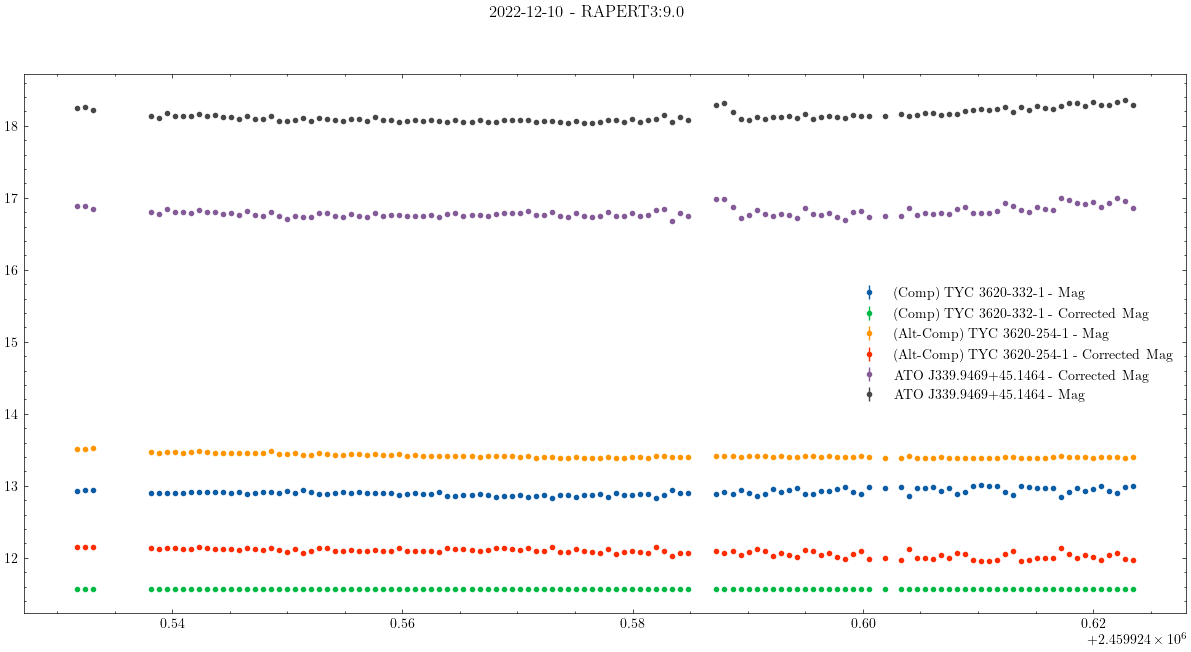

In [7]:
from astropy import units as u

PLOT_INDIVIDUAL = True
ZMAG = 25.0
ITIME = 60.0 * u.second

allObjDf = pd.DataFrame(columns=['MAG', 'MERR', 'FLUX', 'FERR', 'NORM_FLUX', 'OTIME', 'obsv_date', 'julianDate'])
culledPoints = 0
for obsvDate in OBSV_DATES:
	qphotDateResults = QPHOT_RESULTS[obsvDate]
	fltr = CULLED_FLTRS[obsvDate].reset_index(drop=True)
	rapertId = OBSV_DATES_APERS[obsvDate]
	rapert = float(qphotDateResults[f'RAPERT{rapertId}'].iloc[0])

	dateCulledPoints = len(fltr[fltr == False])
	print(f"{obsvDate} - Culled {dateCulledPoints} points")
	culledPoints += dateCulledPoints

	obj_qphot = qphotDateResults[qphotDateResults['LID'] == 1].reset_index(drop=True)
	comp_qphot = qphotDateResults[qphotDateResults['LID'] == COMP_STAR_LID].reset_index(drop=True) # only used for filter below
	alt_comp_qphot = qphotDateResults[qphotDateResults['LID'] == ALT_COMP_LID].reset_index(drop=True)

	# a[mask.reindex(a.index, fill_value=False)]
	obj_qphot = obj_qphot[~np.isnan(comp_qphot[f'MAG{rapertId}'])]
	culled_obj_qphot = obj_qphot[fltr.reindex(obj_qphot.index, fill_value=False)]

	comp_qphot = comp_qphot[~np.isnan(comp_qphot[f'MAG{rapertId}'])]
	culled_comp_qphot = comp_qphot[fltr.reindex(comp_qphot.index, fill_value=False)]
	
	compNanMask = np.isnan(comp_qphot[f'MAG{rapertId}'])
	alt_comp_qphot = alt_comp_qphot[~compNanMask.reindex(alt_comp_qphot.index, fill_value=True)] # filling with Trues since this means that they'd get removed
	culled_alt_comp_qphot = alt_comp_qphot[fltr.reindex(alt_comp_qphot.index, fill_value=False)]

	trend_culled = np.median(culled_obj_qphot[f'FLUX{rapertId}']) * np.ones_like(culled_obj_qphot[f'FLUX{rapertId}'])
	# culled_norm_flux = ((culled_obj_qphot[f'FLUX{rapertId}'] - trend_culled) + np.median(trend_culled)) / np.median(trend_culled)

	# calc differential photometry before calculating error
	magError = culled_comp_qphot[f'MAG{rapertId}'] - COMP_STAR_VMAG
	correctedObjMag = culled_obj_qphot[f'MAG{rapertId}'] - magError
	correctedObjMerr = culled_obj_qphot[f'MERR{rapertId}'] 
	correctedObjFlux = ITIME * 10**((2/5)*(ZMAG - correctedObjMag))

	correctedCompMag = culled_comp_qphot[f'MAG{rapertId}'] - magError
	correctedCompMerr = culled_comp_qphot[f'MERR{rapertId}'] 
	correctedCompFlux = ITIME * 10**((2/5)*(ZMAG - correctedCompMag))
	correctedCompFerr = np.sqrt(
								(correctedCompFlux/EPADU) 
									+ (culled_comp_qphot[f'AREA{rapertId}']*culled_comp_qphot['STDEV']**2)
									+ ((culled_comp_qphot[f'AREA{rapertId}']**2)  * ((culled_comp_qphot['STDEV']**2)/culled_comp_qphot['NSKY']))
							)

	correctedAltCompMag = culled_alt_comp_qphot[f'MAG{rapertId}'] - magError
	correctedAltCompMerr = culled_alt_comp_qphot[f'MERR{rapertId}']
	
	# culled_obj_qphot[f'FERR{rapertId}'] = np.sqrt(
    #                                 (culled_obj_qphot[f'FLUX{rapertId}']/EPADU) 
    #                                    + (culled_obj_qphot[f'AREA{rapertId}']*culled_obj_qphot['STDEV']**2)
    #                                    + ((culled_obj_qphot[f'AREA{rapertId}']**2)  * ((culled_obj_qphot['STDEV']**2)/culled_obj_qphot['NSKY']))
    #                             )
	# culled_norm_ferr = culled_obj_qphot[f'FERR{rapertId}'] / np.median(trend_culled)

	correctedFerr = np.sqrt(
                                    (correctedObjFlux/EPADU) 
                                       + (culled_obj_qphot[f'AREA{rapertId}']*culled_obj_qphot['STDEV']**2)
                                       + ((culled_obj_qphot[f'AREA{rapertId}']**2)  * ((culled_obj_qphot['STDEV']**2)/culled_obj_qphot['NSKY']))
                                )
	originalFerr = np.sqrt( # used for comparison below
                                    (culled_obj_qphot[f'FLUX{rapertId}']/EPADU) 
                                       + (culled_obj_qphot[f'AREA{rapertId}']*culled_obj_qphot['STDEV']**2)
                                       + ((culled_obj_qphot[f'AREA{rapertId}']**2)  * ((culled_obj_qphot['STDEV']**2)/culled_obj_qphot['NSKY']))
                                )
	
	
	# culled_norm_ferr = culled_obj_qphot[f'FERR{rapertId}'] / np.median(trend_culled)

	# not using normalized flux for now, instead working with differential fluxes
	dateDf = pd.DataFrame(data={
		'obsv_date': obsvDate,
		'julianDate': culled_obj_qphot['julianDate'],
		'OTIME': culled_obj_qphot['OTIME'],
		'MAG': culled_obj_qphot[f'MAG{rapertId}'],
		'MERR': culled_obj_qphot[f'MERR{rapertId}'],
		'FLUX': correctedObjFlux,
		'FERR': correctedFerr,
		'RAPERT': rapert*np.ones_like(correctedObjFlux)
	})
	allObjDf = pd.concat([allObjDf, dateDf])

	if PLOT_INDIVIDUAL:
		print(f"Area = {culled_obj_qphot[f'AREA{rapertId}'].iloc[0]}")
		print(f"Std dev. = {culled_obj_qphot['STDEV'].iloc[0]}")
		print(f"Nsky = {culled_obj_qphot['NSKY'].iloc[0]}")

		# custom code to have subplot extend both spots in grid
		fig = plt.figure(figsize=(15,12))
		gs = fig.add_gridspec(3, 2)
		axs = np.ndarray((3, 2), dtype=object)
		for i in range(2):
			for ii in range(2):
				axs[i, ii] = fig.add_subplot(gs[i, ii])
		axs[2, 0] = fig.add_subplot(gs[2,:])

		axs[0,0].errorbar(obj_qphot['julianDate'], obj_qphot[f'FLUX{rapertId}'], obj_qphot[f'MERR{rapertId}'], label=STAR_LIDS[1], fmt='.')
		axs[0,0].errorbar(culled_obj_qphot['julianDate'], culled_obj_qphot[f'FLUX{rapertId}'], originalFerr, label=f"{STAR_LIDS[1]} - Culled", fmt='.')
		axs[0,0].plot(culled_obj_qphot['julianDate'], trend_culled, label='Median')
		axs[0,0].legend()

		axs[0,1].errorbar(culled_obj_qphot['julianDate'], correctedObjFlux, correctedFerr, label=f"{STAR_LIDS[1]} - Corrected - Culled", fmt='.')
		axs[0,1].legend()

		axs[1,0].scatter(culled_obj_qphot['julianDate'], originalFerr)
		axs[1,0].set_title("Original Flux Error")

		axs[1,1].scatter(culled_obj_qphot['julianDate'], correctedFerr)
		axs[1,1].set_title("Corrected Flux Error")

		axs[2,0].scatter(culled_comp_qphot['julianDate'], magError)
		axs[2,0].set_title("Differential magnitude error")

		fig.suptitle(f"{obsvDate} - RAPERT{rapertId}:{qphotDateResults[f'RAPERT{rapertId}'].iloc[0]}")
		# axs[1,0].hist(originalFerr, bins=100)
		# axs[1,1].hist(culled_obj_qphot[f'FERR{rapertId}'], bins=100)

		# fig, axs = plt.subplots(2, 1, figsize=(15, 14))
		fig, ax = plt.subplots(1, 1, figsize=(15, 7))
		axs = [ax] # to avoid changing below code for now
		axs[0].errorbar(culled_comp_qphot['julianDate'], culled_comp_qphot[f'MAG{rapertId}'], culled_comp_qphot[f'MERR{rapertId}'], label=f"(Comp) {STAR_LIDS[COMP_STAR_LID]} - Mag", fmt='.')
		axs[0].errorbar(culled_comp_qphot['julianDate'], correctedCompMag, correctedCompMerr, label=f"(Comp) {STAR_LIDS[COMP_STAR_LID]} - Corrected Mag", fmt='.')
		
		axs[0].errorbar(culled_alt_comp_qphot['julianDate'], culled_alt_comp_qphot[f'MAG{rapertId}'], culled_alt_comp_qphot[f'MERR{rapertId}'], label=f"(Alt-Comp) {STAR_LIDS[ALT_COMP_LID]} - Mag", fmt='.')
		axs[0].errorbar(culled_alt_comp_qphot['julianDate'], correctedAltCompMag, correctedAltCompMerr, label=f"(Alt-Comp) {STAR_LIDS[ALT_COMP_LID]} - Corrected Mag", fmt='.')

		axs[0].errorbar(culled_obj_qphot['julianDate'], correctedObjMag, correctedObjMerr, label=f"{STAR_LIDS[1]} - Corrected Mag", fmt='.')
		axs[0].errorbar(culled_obj_qphot['julianDate'], culled_obj_qphot[f'MAG{rapertId}'], culled_obj_qphot[f'MERR{rapertId}'], label=f"{STAR_LIDS[1]} - Mag", fmt='.')
		
		axs[0].legend()

		# axs[1].errorbar(culled_comp_qphot['julianDate'], correctedCompFlux, correctedCompFerr, label=f"(Comp) {STAR_LIDS[COMP_STAR_LID]} - Corrected Flux", fmt='.')
		# axs[1].legend()

		fig.suptitle(f"{obsvDate} - RAPERT{rapertId}:{qphotDateResults[f'RAPERT{rapertId}'].iloc[0]}")
		plt.show()

Total culled points: 271


,MAG,MERR,FLUX,FERR,NORM_FLUX,OTIME,obsv_date,julianDate,RAPERT
0,17.981,0.031,112240.928422,1092.332444,NaN,2022-10-21 22:54:21.841000-05:00,2022-10-21,2.459875e+06,20.0
1,18.061,0.027,105232.830111,880.897129,NaN,2022-10-21 22:55:22.219000-05:00,2022-10-21,2.459875e+06,20.0
2,18.024,0.030,107386.886365,1014.654385,NaN,2022-10-21 22:56:22.714000-05:00,2022-10-21,2.459875e+06,20.0
3,17.929,0.021,116882.973197,781.512461,NaN,2022-10-21 22:57:23.081000-05:00,2022-10-21,2.459875e+06,20.0
4,18.002,0.020,109585.034926,707.301735,NaN,2022-10-21 22:58:23.606000-05:00,2022-10-21,2.459875e+06,20.0
...,...,...,...,...,...,...,...,...,...
120,18.291,0.013,107485.838904,366.915207,NaN,2022-12-10 20:52:39.875000-06:00,2022-12-10,2.459925e+06,9.0
121,18.288,0.017,101894.619148,451.144250,NaN,2022-12-10 20:53:40.007000-06:00,2022-12-10,2.459925e+06,9.0
122,18.329,0.021,95181.216329,547.231803,NaN,2022-12-10 20:54:40.156000-06:00,2022-12-10,2.459925e+06,9.0
123,18.361,0.016,99575.214446,399.804131,NaN,2022-12-10 20:55:40.318000-06:00,2022-12-10,2.459925e+06,9.0


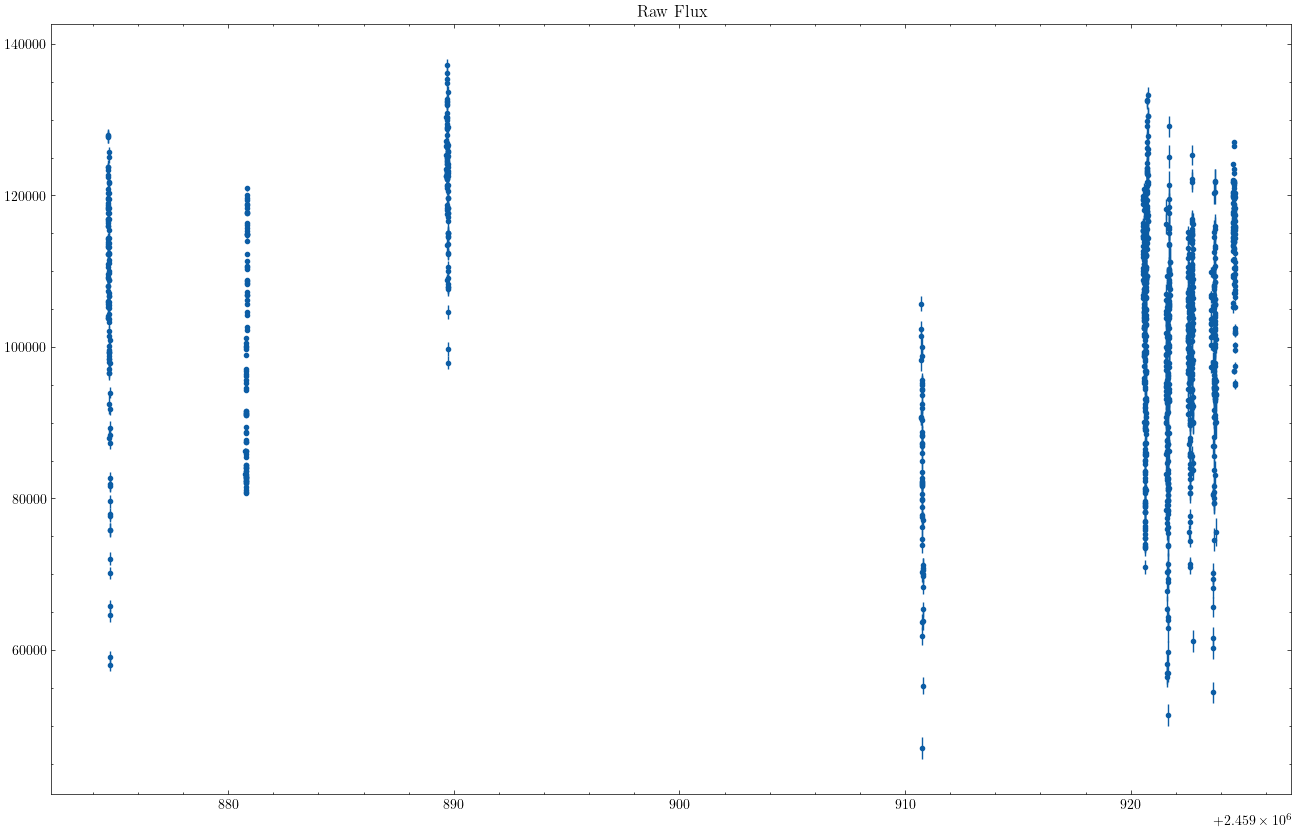

In [8]:
# %matplotlib widget
%matplotlib inline

print("Total culled points:", culledPoints)

# fig, axs = plt.subplots(2, 1, figsize=(16,10))
# axs[0].errorbar(allObjDf['julianDate'], allObjDf['NORM_FLUX'], allObjDf['NORM_FERR'], fmt='.')
# axs[1].errorbar(allObjDf['julianDate'], allObjDf['FLUX'], allObjDf['FERR'], fmt='.')

# axs[0].set_title("Normalized Flux")
# axs[1].set_title("Raw Flux")

fig, ax = plt.subplots(1, 1, figsize=(16,10))
ax.errorbar(allObjDf['julianDate'], allObjDf['FLUX'], allObjDf['FERR'], fmt='.')
ax.set_title("Raw Flux")

# fig, ax = plt.subplots(1, 1, figsize=(16, 8))
# ax.errorbar(allObjDf['julianDate'], allObjDf['FLUX'], allObjDf['FERR'], fmt='.')
allObjDf

In [9]:
OBJ_DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data"

In [10]:
allObjDf.to_csv(f"{OBJ_DATA_DIR}/culledObjDataLID2.csv")
print(f"{OBJ_DATA_DIR}/culledObjDataLID2.csv")

/home/ramon/uanl/Tesis/Backup Data/culledObjDataLID2.csv
